<a href="https://colab.research.google.com/github/saketkc/pyro-rethinking/blob/master/Chapters/04_Chapter04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 04 - Linear Models

In [ ]:
!pip install torch torchvision pyro-ppl proplot black blackcellmagic

In [ ]:
%load_ext blackcellmagic
import warnings

import pandas as pd
import proplot as plot
import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.ops.stats as stats
import pyro.optim
import seaborn as sns
import torch
import torch.distributions.constraints as constraints
import torch.tensor as tensor
from pyro.contrib.autoguide import AutoLaplaceApproximation

warnings.filterwarnings("ignore")
%pylab inline
pyro.set_rng_seed(42)

plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Code 4.1

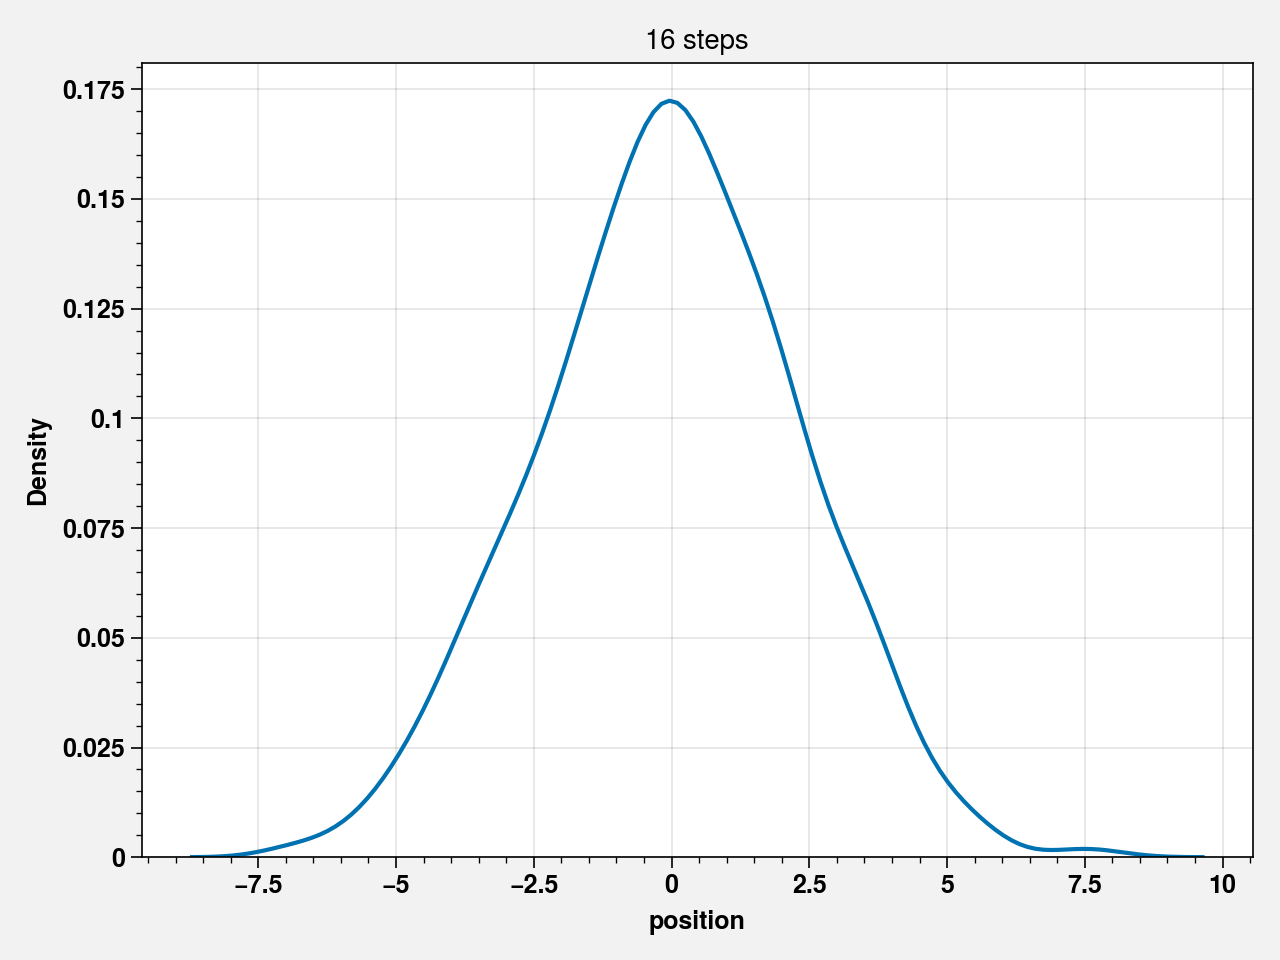

In [ ]:
# Normal by addition
pos = dist.Uniform(tensor(-1.), tensor(1.)).sample(torch.Size([1000, 16])).sum(1)
fig, ax = plt.subplots()
sns.kdeplot(pos.numpy(), ax=ax)
ax.set_xlabel("position")
ax.set_ylabel("Density")
ax.set_title("16 steps")
fig.tight_layout()

# Code 4.2

In [ ]:
# Normal by multiplication
(dist.Uniform(tensor(0.), tensor(1.)).sample(torch.Size([12])) + 1).prod()

tensor(116.2093)

# Code 4.3

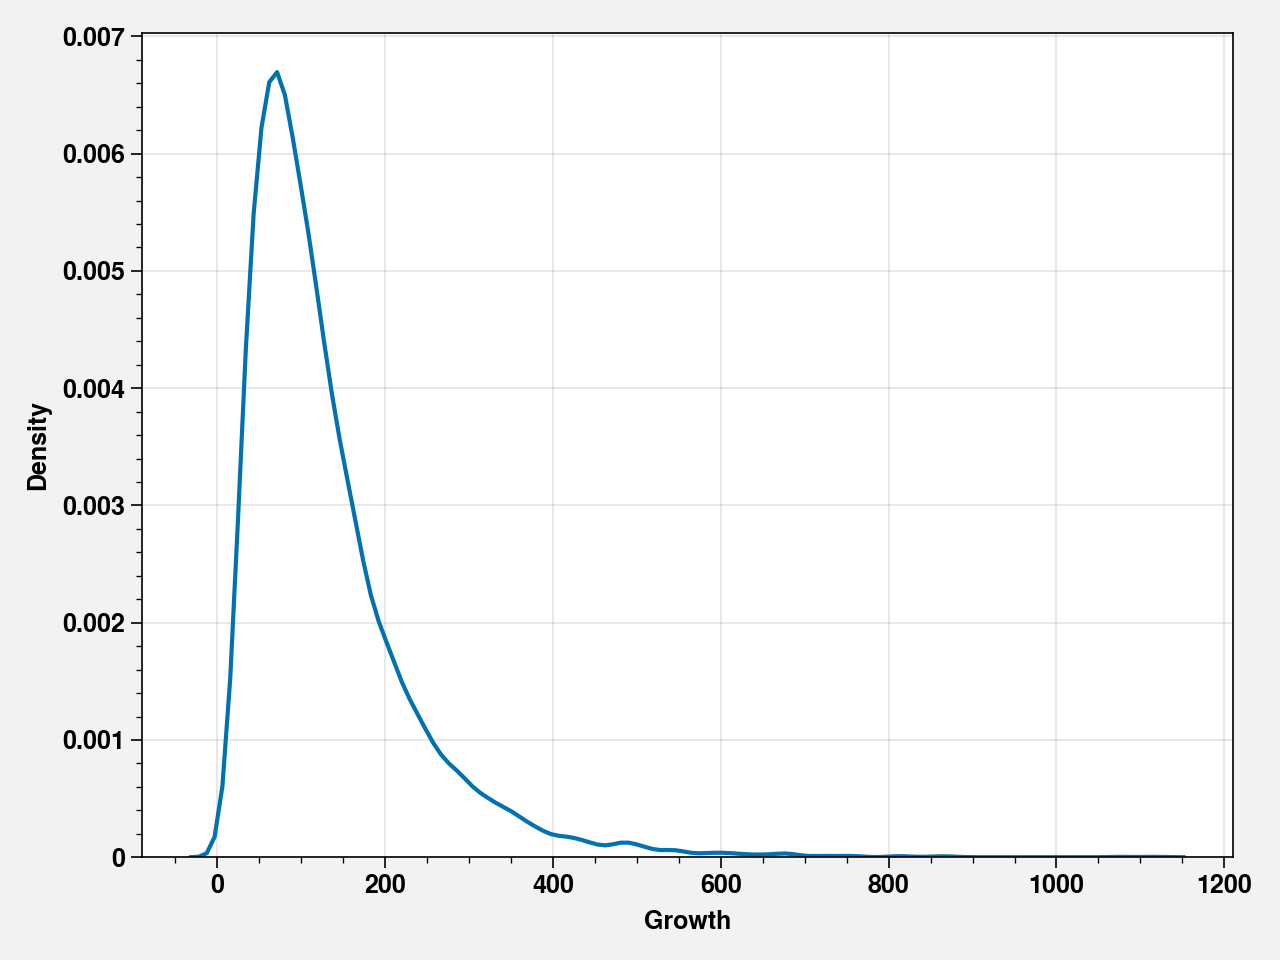

In [ ]:
# Normal by multiplication

growth = (dist.Uniform(tensor(0.), tensor(1.)).sample(torch.Size([10000,12])) + 1).prod(1)
fig, ax = plt.subplots()
sns.kdeplot(growth.numpy(), ax=ax)
ax.set_xlabel("Growth")
ax.set_ylabel("Density")
fig.tight_layout()

# Code 4.4

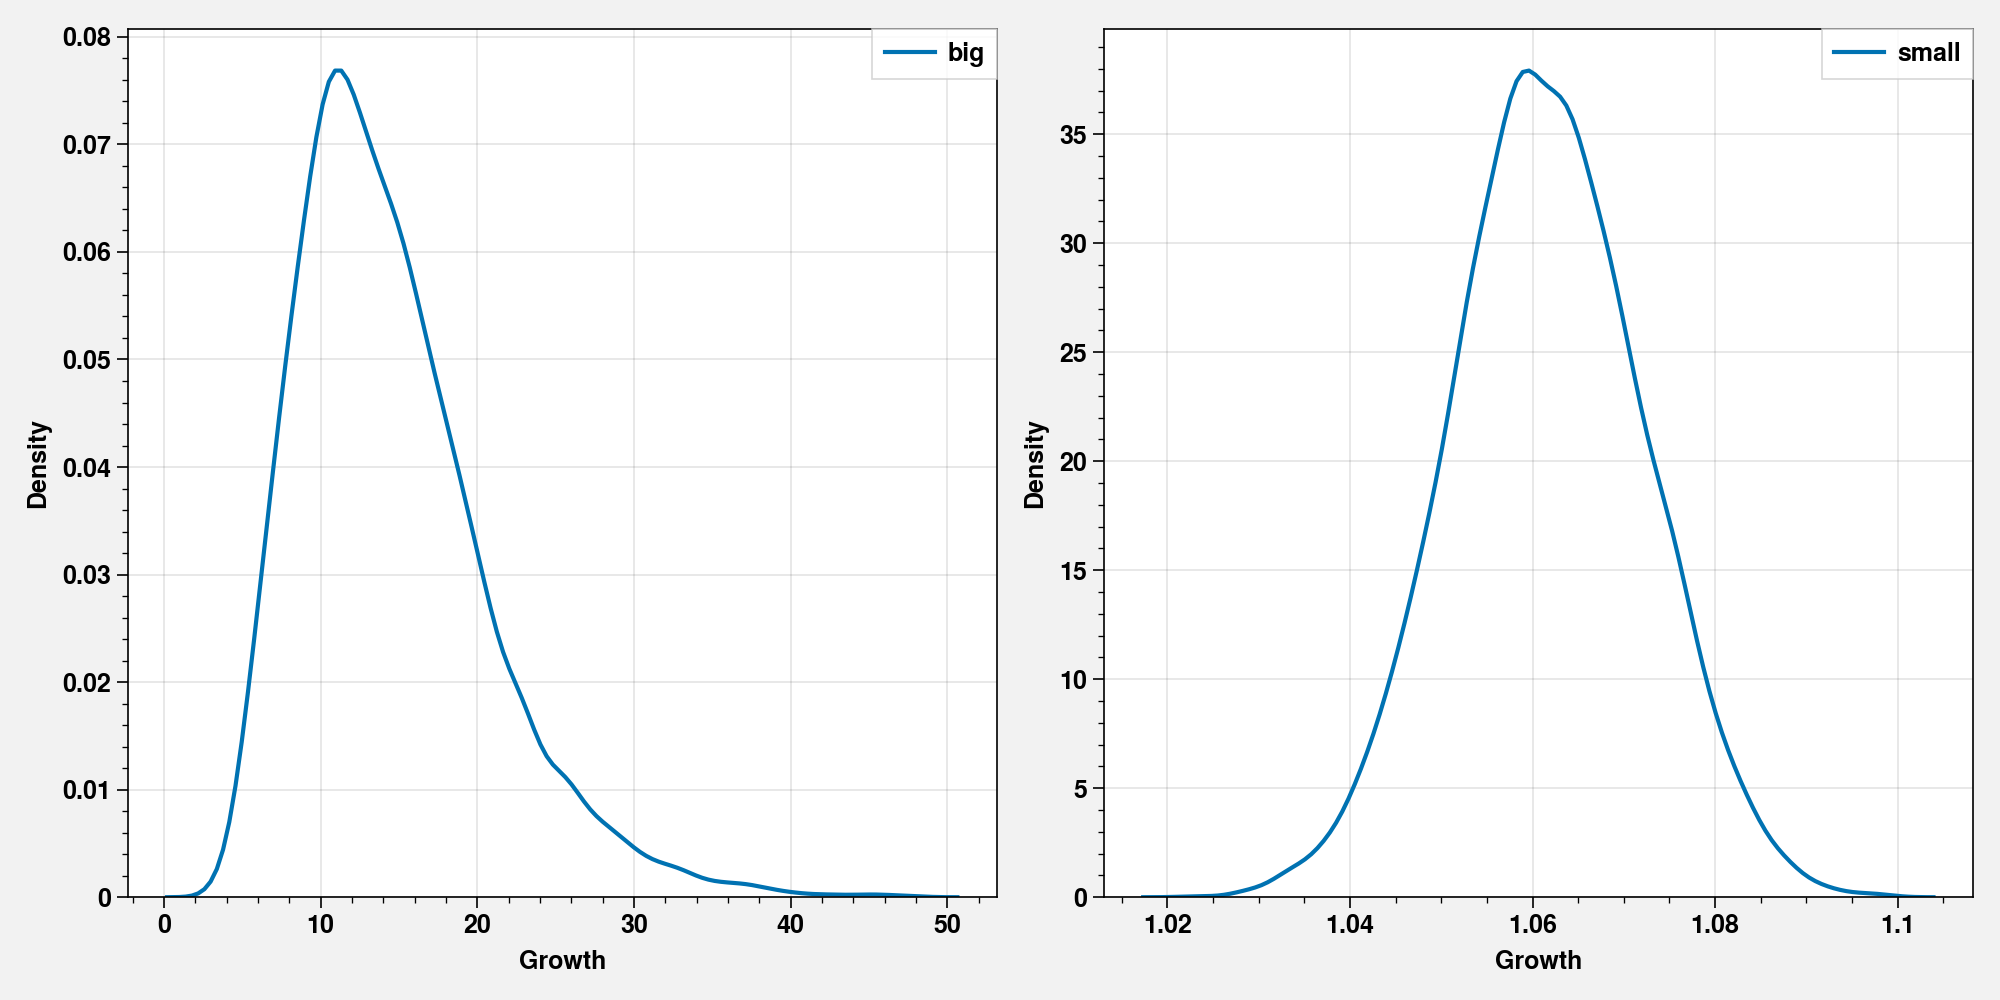

In [ ]:
# Normal by multiplication

big = (dist.Uniform(tensor(0.), tensor(.5)).sample(torch.Size([10000,12])) + 1).prod(1)
small = (dist.Uniform(tensor(0.), tensor(.01)).sample(torch.Size([10000,12])) + 1).prod(1)

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
sns.kdeplot(big.numpy(), ax=ax, label='big')
ax.set_xlabel("Growth")
ax.set_ylabel("Density")
ax.legend()
ax = plt.subplot(122)
sns.kdeplot(small.numpy(), ax=ax, label='small')
ax.set_xlabel("Growth")
ax.set_ylabel("Density")
ax.legend()

fig.tight_layout()

# Code 4.5

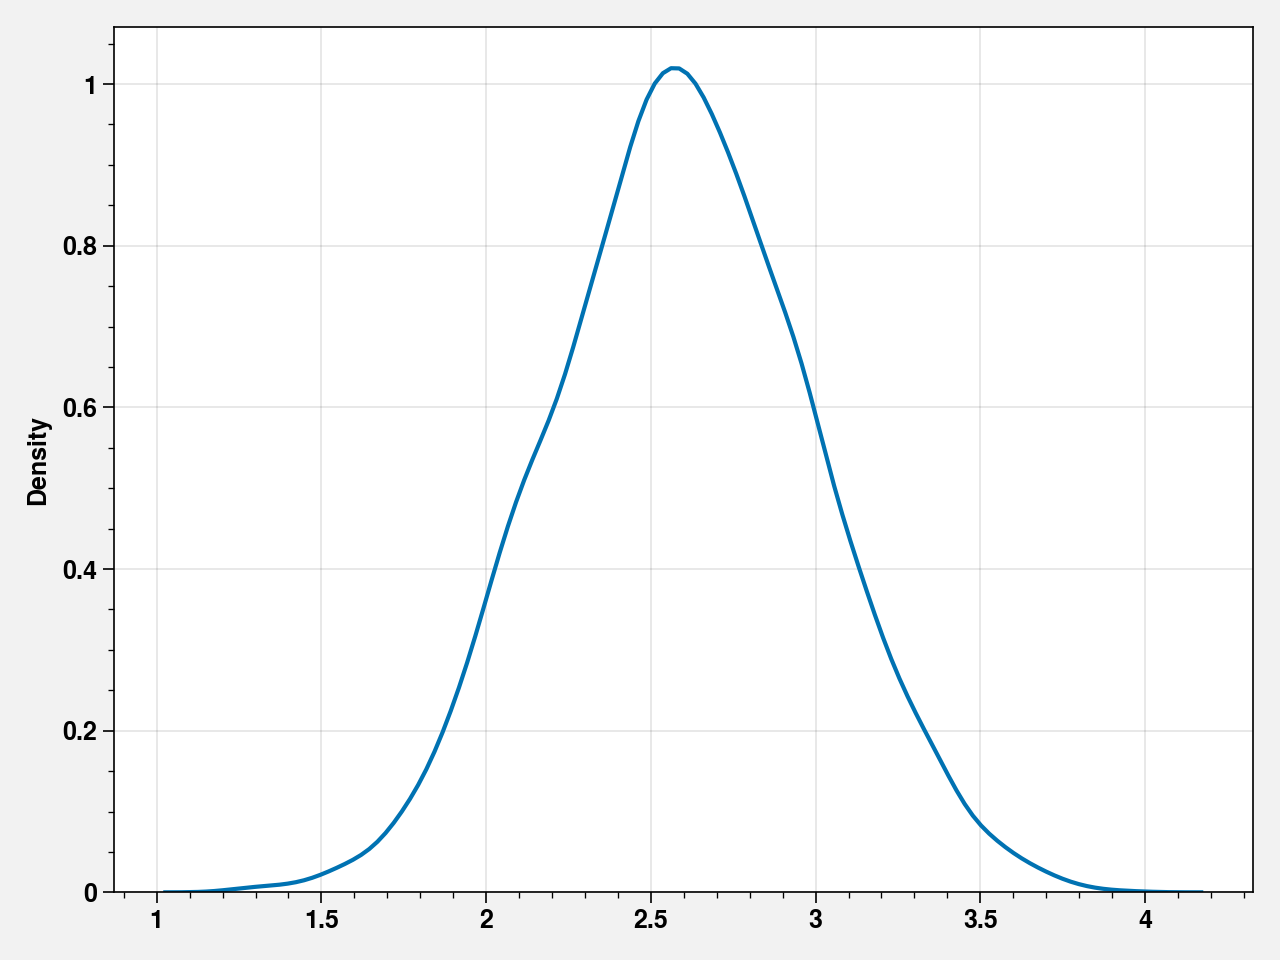

In [ ]:
# Normal by log-multiplication

log_big = torch.log((dist.Uniform(tensor(0.), tensor(.5)).sample(torch.Size([10000,12])) + 1).prod(1))
fig, ax = plt.subplots()
sns.kdeplot(log_big.numpy(), ax=ax)
#ax.set_xlabel("Growth")
ax.set_ylabel("Density")
fig.tight_layout()

# Code 4.6

In [ ]:
w = 6
n = 9
p_grid = torch.linspace(start=0, end=1, steps=100)
prior = tensor([1.0] * 1000)
posterior = dist.Binomial(total_count=n, probs=p_grid).log_prob(tensor(float(w))).exp() * dist.Uniform(0,1).log_prob(p_grid).exp()
posterior = posterior/posterior.sum()

# Code 4.7




In [ ]:
!wget -c https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv
howell = pd.read_csv("Howell1.csv", sep=";")

--2020-07-04 20:43:59--  https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



# Code 4.8

In [ ]:
howell.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


# Code 4.9

In [ ]:
howell['height']

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

# Code 4.10

In [ ]:
howell2 = howell.loc[howell.age>=18]

# Code 4.11

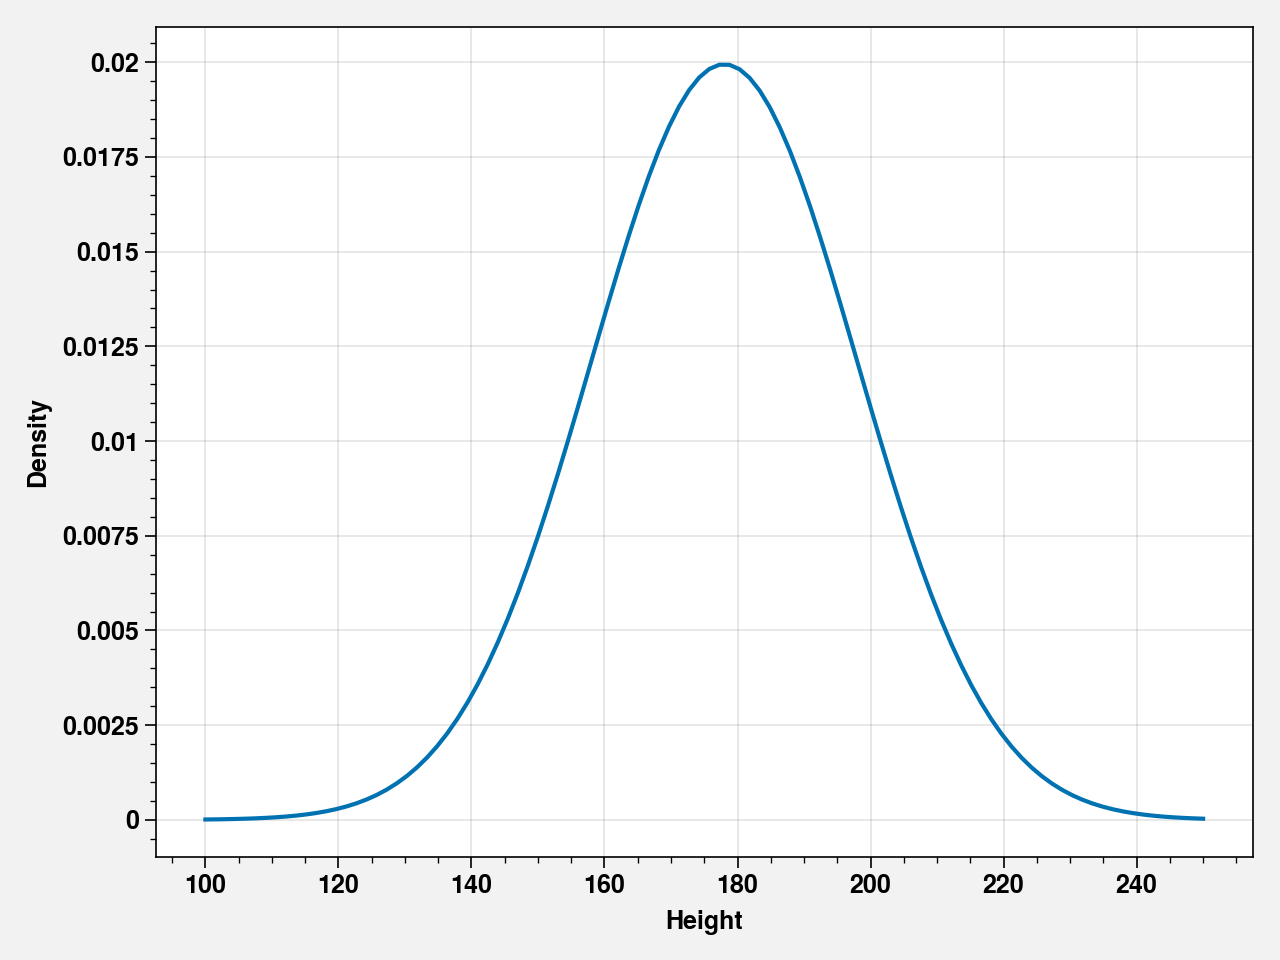

In [ ]:
mu = dist.Normal(tensor(178.), tensor(20.)).log_prob(torch.linspace(100, 250, steps=100)).exp()
fig, ax = plt.subplots()
ax.plot(torch.linspace(100, 250, steps=100), mu)
ax.set_xlabel("Height")
ax.set_ylabel("Density")
fig.tight_layout()

# Code 4.12

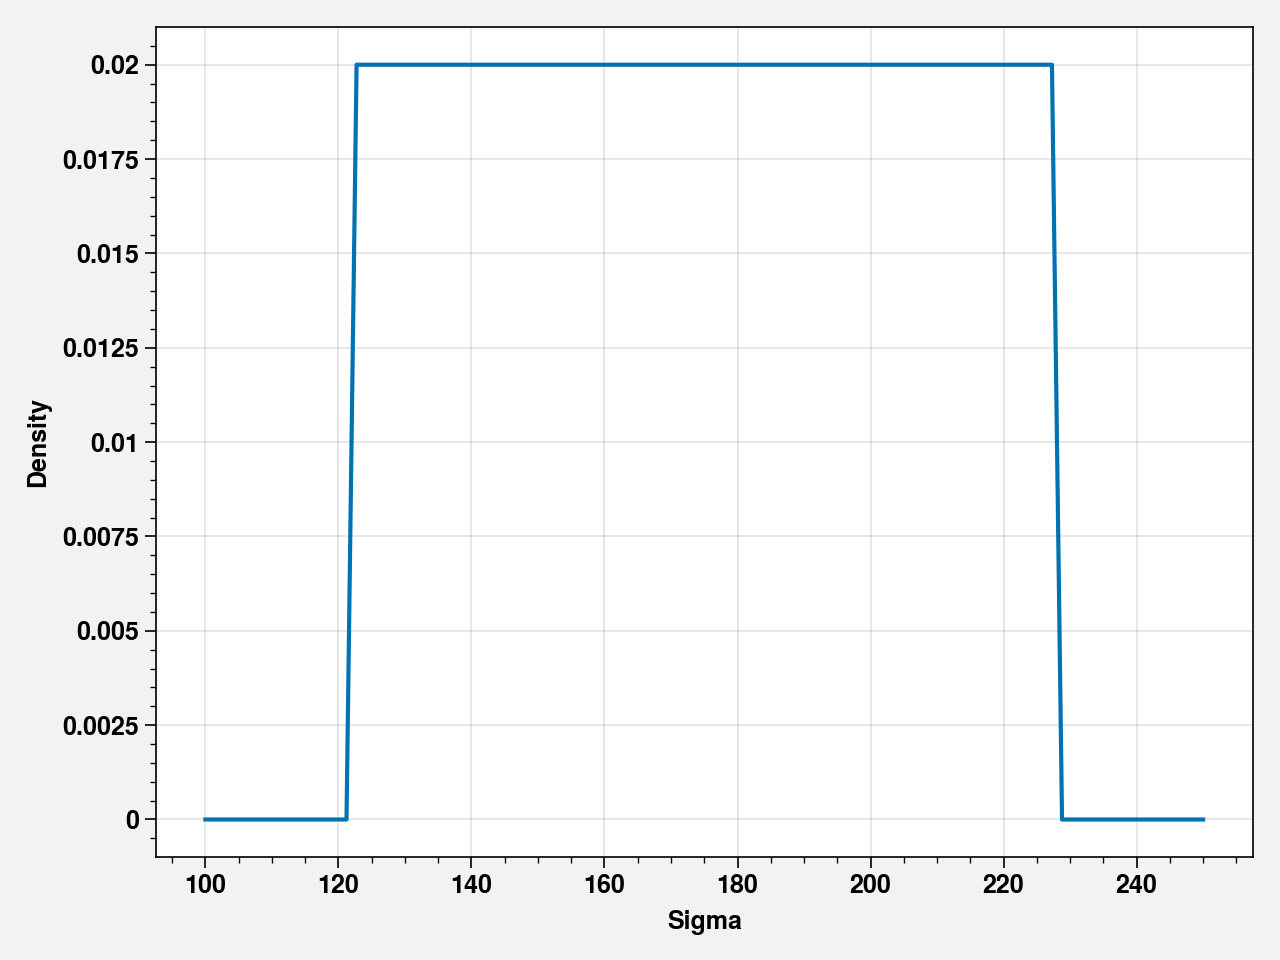

In [ ]:
sigma = dist.Uniform(tensor(0.), tensor(50.)).log_prob(torch.linspace(-10, 60, steps=100)).exp()
fig, ax = plt.subplots()
ax.plot(torch.linspace(100, 250, steps=100), sigma)
ax.set_xlabel("Sigma")
ax.set_ylabel("Density")
fig.tight_layout()

# Code 4.13

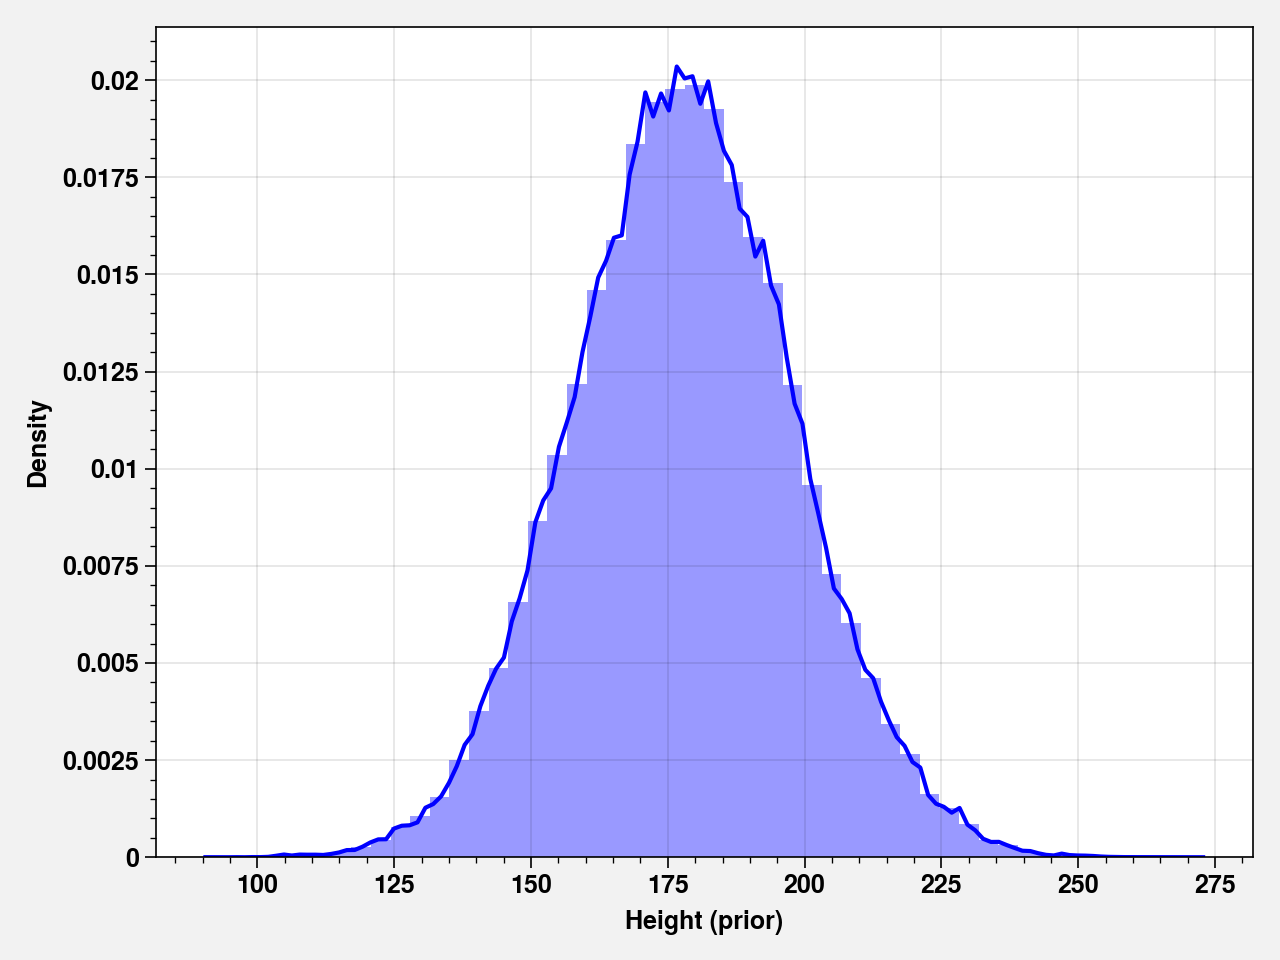

In [ ]:
sample_mu = dist.Normal(tensor(178.), tensor(20.)).sample(torch.Size([10000]))
sample_sigma = dist.Uniform(tensor(0.), tensor(5.)).sample(torch.Size([10000]))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(torch.Size([10000]))
fig, ax = plt.subplots()
sns.distplot(prior_h.numpy(), color='blue', hist=True, kde=True, ax=ax)
ax.set_xlabel('Height (prior)')
ax.set_ylabel('Density')
fig.tight_layout()

# Code 4.14

In [ ]:
import itertools
mu_list = torch.linspace(tensor(140.), tensor(160.), steps=200)
sigma_list = torch.linspace(tensor(4.), tensor(9.), steps=200)
post = pd.DataFrame(itertools.product(mu_list.numpy(), sigma_list.numpy()), columns=['mu', 'sigma'])
ll = post.apply(lambda row: dist.Normal(loc=row.mu, scale=row.sigma).log_prob(tensor(howell2.height)).sum(), axis=1)
prod =  tensor(ll) + dist.Normal(loc=tensor(178.), scale=tensor(20.)).log_prob(tensor(post.mu.values)) + dist.Uniform(tensor(0.), tensor(50.)).log_prob(tensor(post.sigma.values))
post_prob = (prod - prod.max()).exp()

# Code 4.15

(<Figure size 640x480 with 1 Axes>, None)

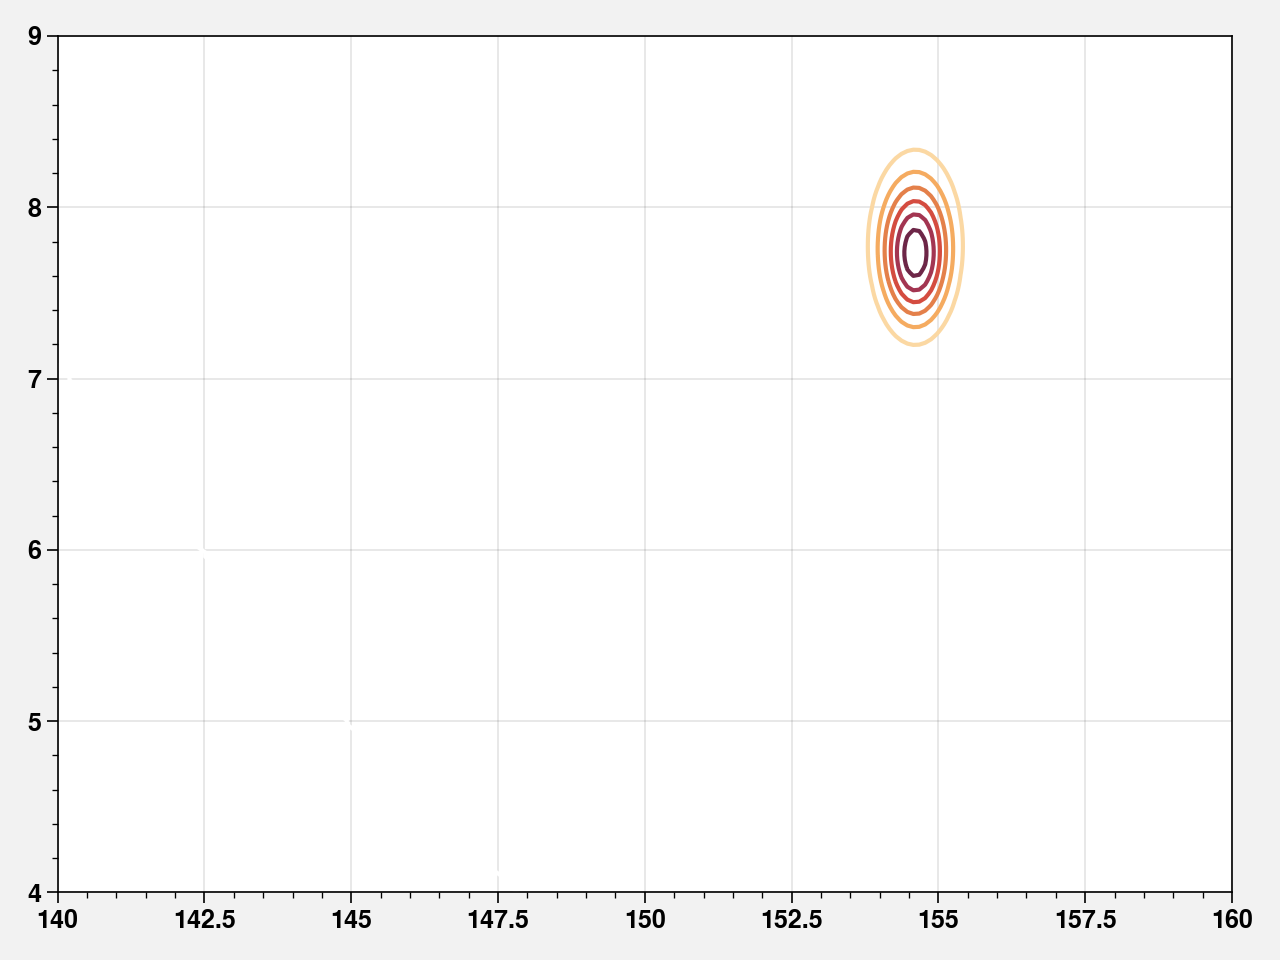

In [ ]:
fig, ax = plt.subplots()
ax.contour(post["mu"].values.reshape(200, 200), post["sigma"].values.reshape(200, 200),
           post_prob.numpy().reshape(200, 200))
fig,tight_layout()


# Code 4.16

(<Figure size 640x480 with 1 Axes>, None)

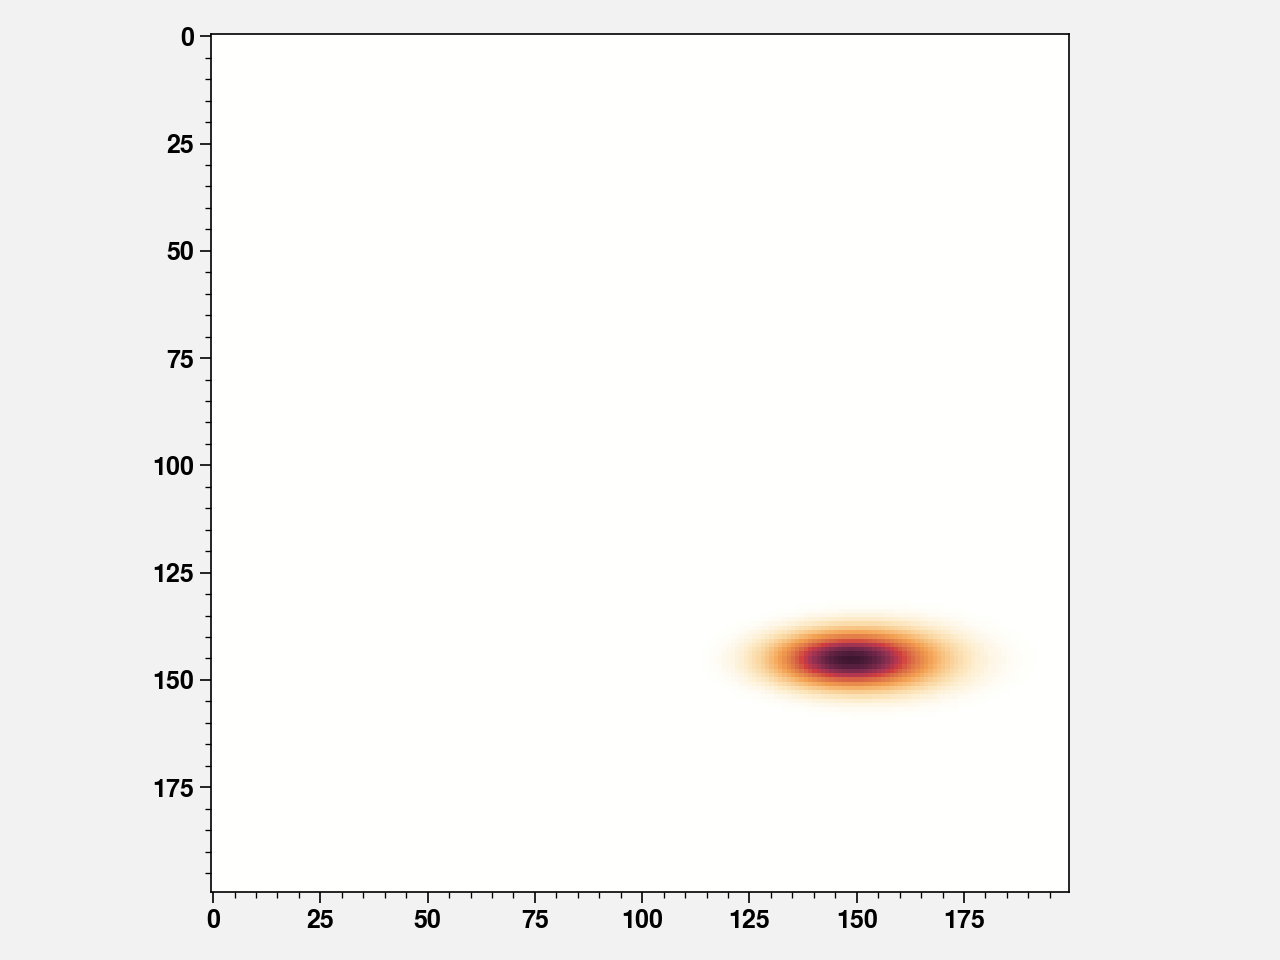

In [ ]:
fig, ax = plt.subplots()
ax.imshow(post_prob.numpy().reshape(200, 200))
ax.grid(False)
fig,tight_layout()

# Code 4.17

In [ ]:
# sample posterior

sample_rows = torch.multinomial(input=post_prob, num_samples=10000,
                                replacement=True)
sample_mu = post["mu"][sample_rows.numpy()]
sample_sigma = post["sigma"][sample_rows.numpy()]

# Code 4.18

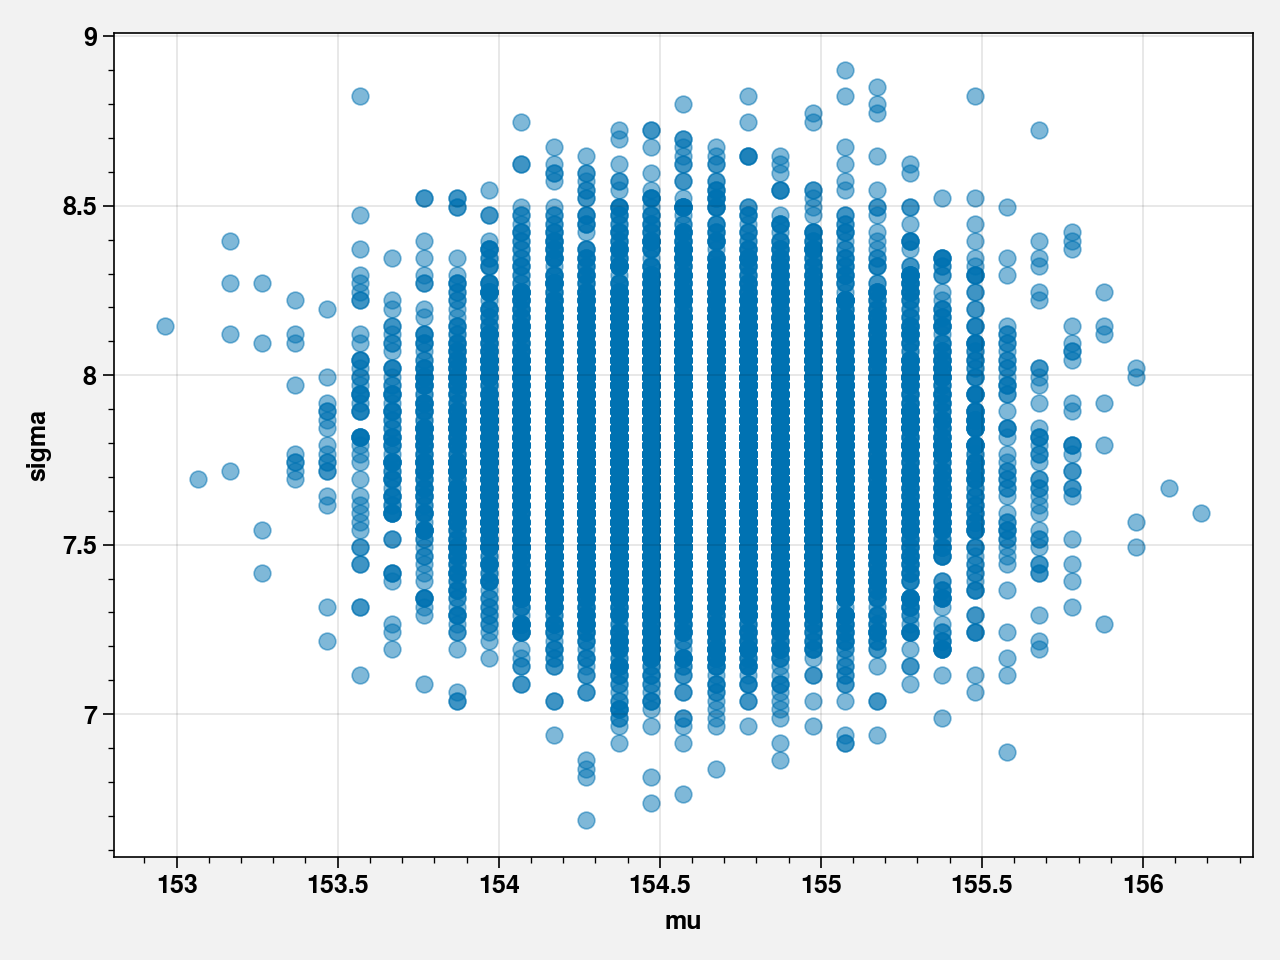

In [ ]:
fig, ax = plt.subplots()
ax.scatter(sample_mu, sample_sigma, alpha=0.5)
ax.set_xlabel("mu")
ax.set_ylabel("sigma")
fig.tight_layout()

# Code 4.19

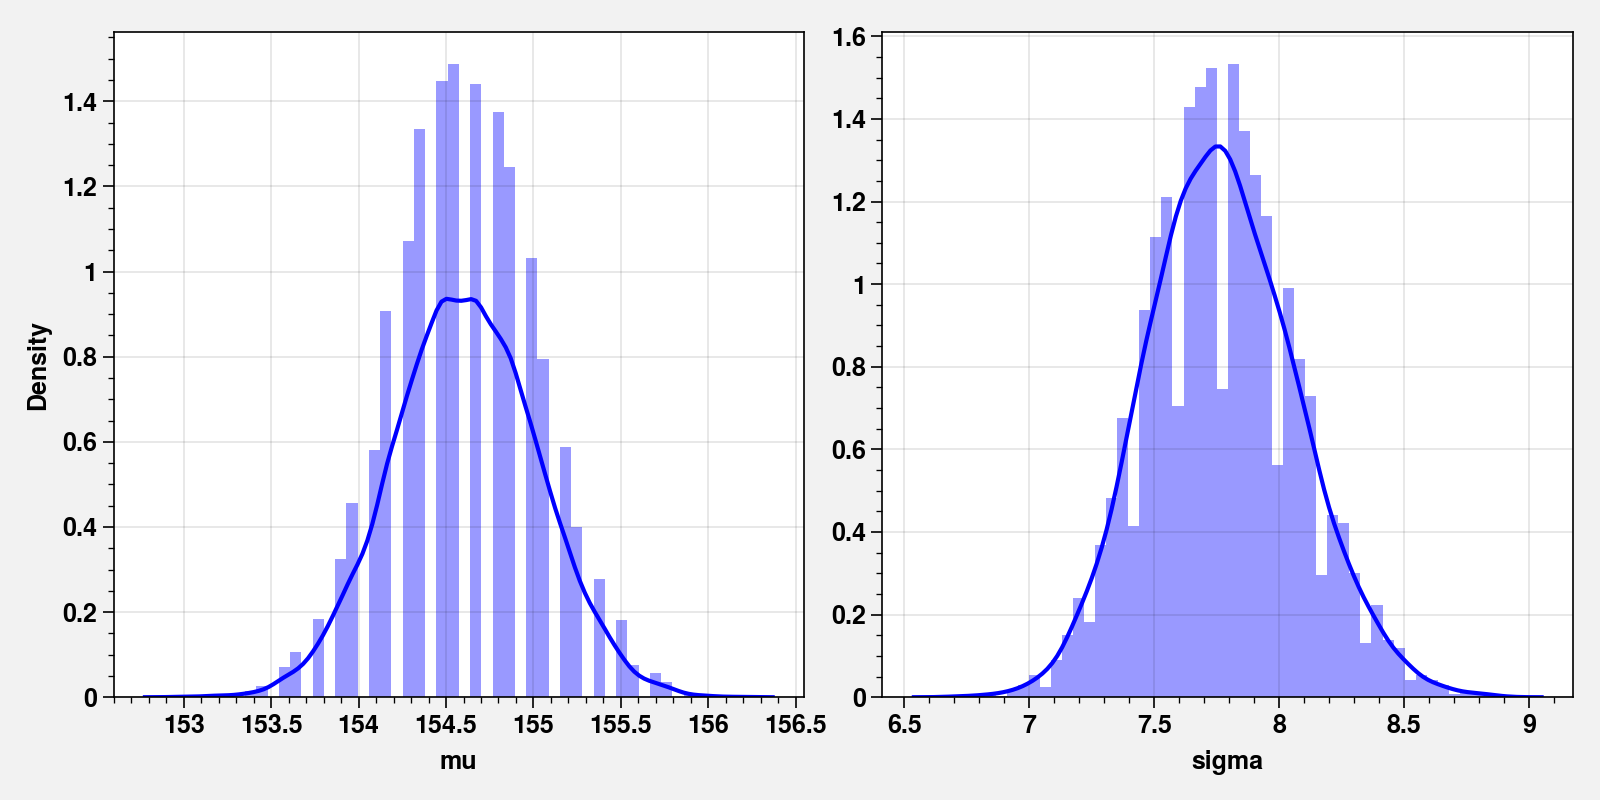

In [ ]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(121)
ax.set_ylabel('Density')
sns.distplot(sample_mu, ax=ax, color='blue')

ax = plt.subplot(122)
sns.distplot(sample_sigma, ax=ax, color='blue')

fig.tight_layout()

# Code 4.20


In [ ]:
import pyro.ops.stats as stats
print(stats.hpdi(tensor(sample_mu.values), 0.89))
print(stats.hpdi(tensor(sample_sigma.values), 0.89))

tensor([154.0704, 155.3769], dtype=torch.float64)
tensor([7.3166, 8.2462], dtype=torch.float64)


# Code 4.21



In [ ]:
d3 = stats.resample(tensor(howell2.height), num_samples=20)

# Code 4.22

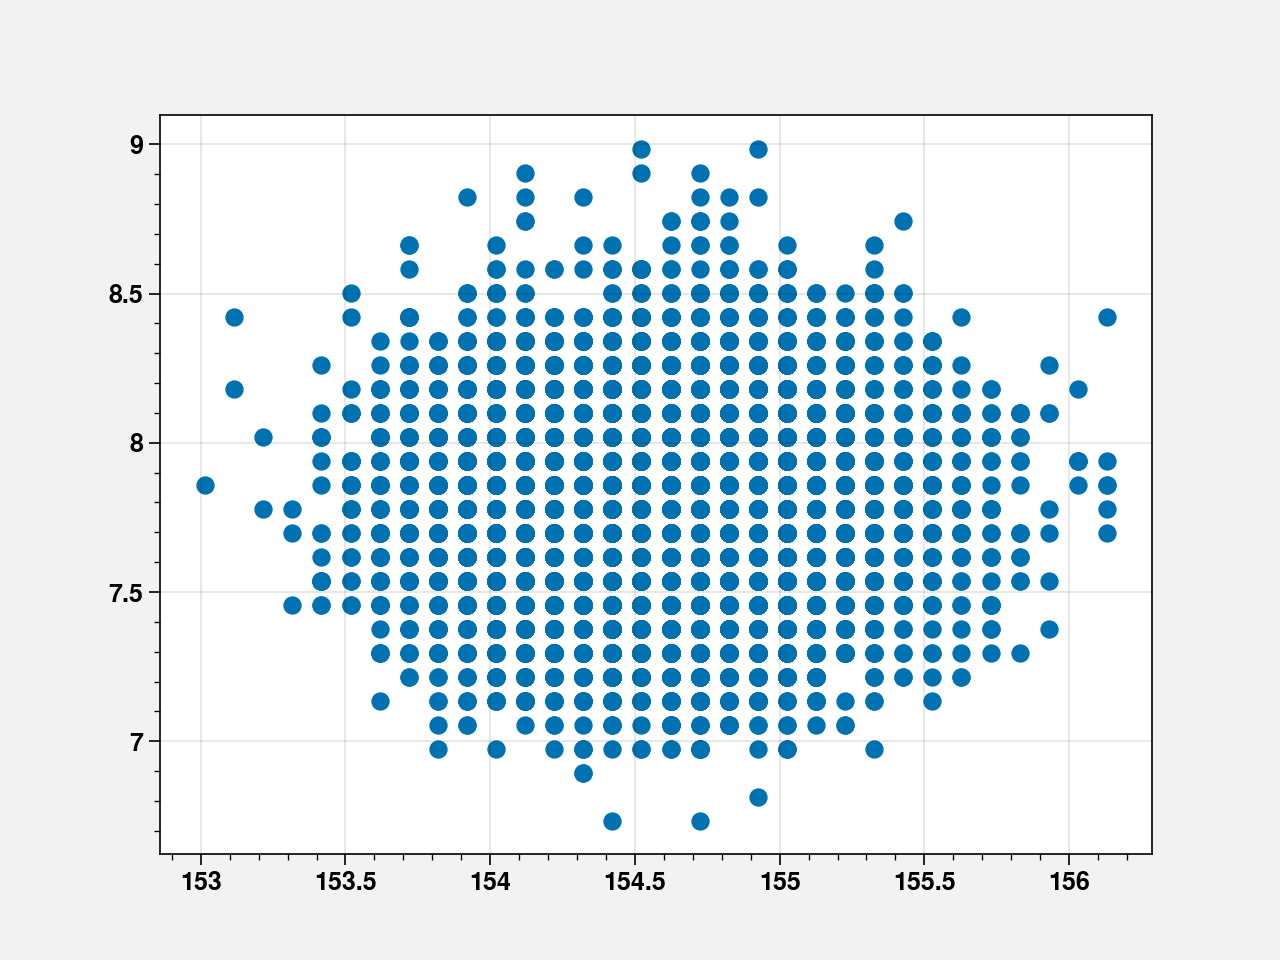

In [ ]:
mu_list = torch.linspace(tensor(150.), tensor(170.), steps=200)
sigma_list = torch.linspace(tensor(4.), tensor(20.), steps=200)
post = pd.DataFrame(itertools.product(mu_list.numpy(), sigma_list.numpy()), columns=['mu', 'sigma'])
ll = post.apply(lambda row: dist.Normal(loc=row.mu, scale=row.sigma).log_prob(tensor(howell2.height)).sum(), axis=1)
prod =  tensor(ll) + dist.Normal(loc=tensor(178.), scale=tensor(20.)).log_prob(tensor(post.mu.values)) + dist.Uniform(tensor(0.), tensor(50.)).log_prob(tensor(post.sigma.values))
post_prob = (prod - prod.max()).exp()


sample_rows = torch.multinomial(input=post_prob, num_samples=10000,
                                replacement=True)
sample2_mu = post["mu"][sample_rows.numpy()]
sample2_sigma = post["sigma"][sample_rows.numpy()]


fig, ax = plt.subplots()
ax.scatter(sample2_mu, sample2_sigma)

# Code 4.23

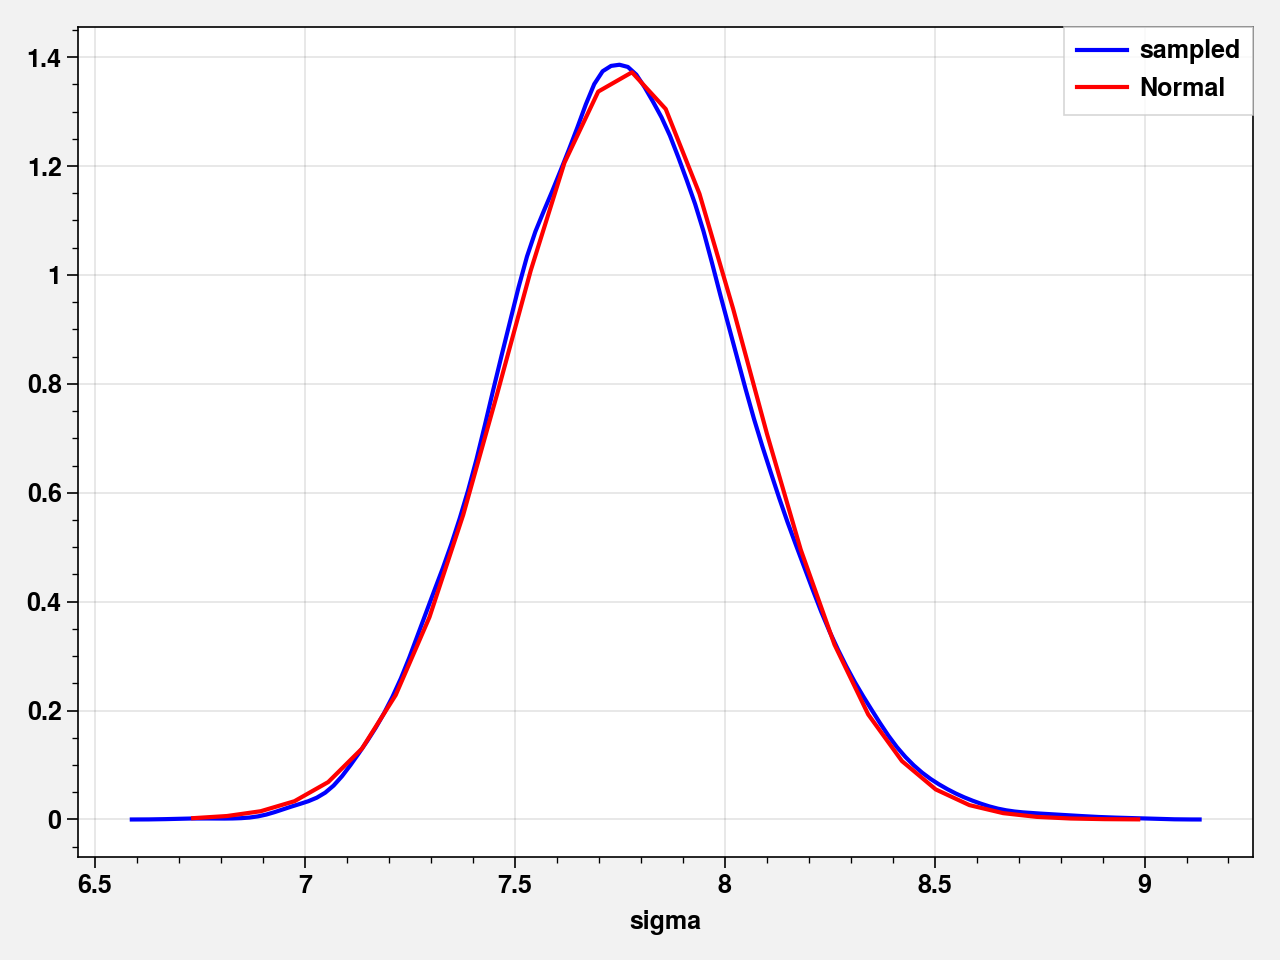

In [ ]:
fig, ax = plt.subplots()
sns.distplot(sample2_sigma, color='blue', ax=ax, hist=False, label='sampled')
y = dist.Normal(tensor(sample2_sigma.mean()), 
                tensor(sample2_sigma.std())).log_prob(tensor(sample2_sigma.values)).exp().numpy()
sns.lineplot(sample2_sigma.values.tolist(), y.tolist(), color='red', label='Normal', linestyle='-.', ax=ax)
ax.legend()
fig.tight_layout()

# Code 4.24


In [ ]:
howell2 = howell.loc[howell.age>=18]

# Code 4.25

mu =  154.60586547851562
sigma =  7.731331825256348


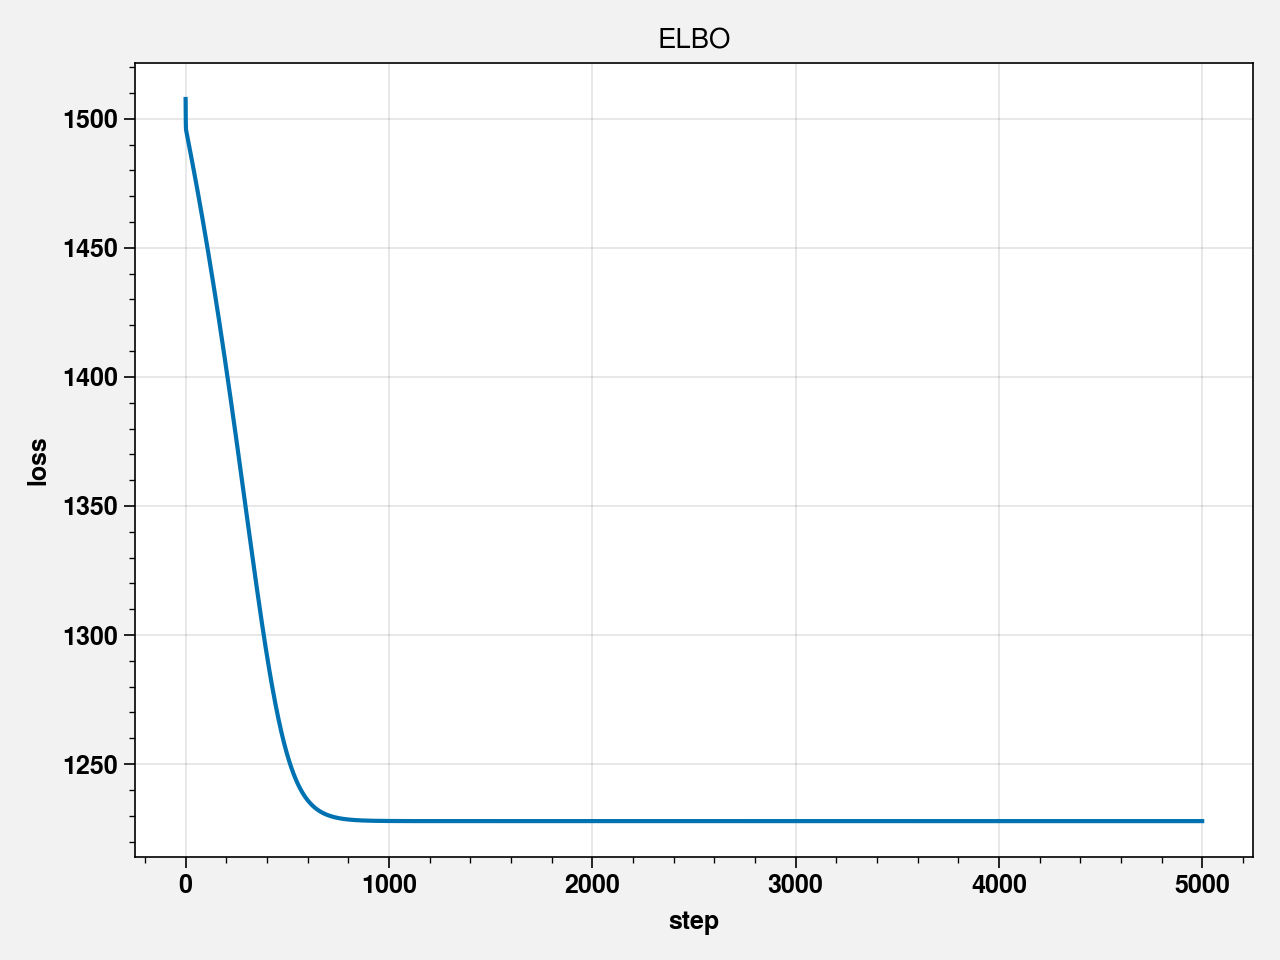

In [ ]:
def model41():
    mu = pyro.sample("mu", dist.Normal(tensor(178.), tensor(20.)))
    sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(50.)))
    height = pyro.sample("height", dist.Normal(mu, sigma))#,obs=height)
    return height 

def guide41():
    mu_param = pyro.param(
        "mu_param", tensor(140.)
    )
    sigma_param = pyro.param(
        "sigma_param", tensor(20.), constraint=constraints.positive
    )
    return pyro.sample("mu", dist.Delta(mu_param)), pyro.sample("sigma", dist.Delta(sigma_param))

pyro.clear_param_store()
conditioned41 = pyro.condition(model41, data={"height": tensor(howell2['height'], dtype=torch.float)})
svi = pyro.infer.SVI(model=conditioned41,
                     guide=guide41,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum": 0.1}),
                     loss=pyro.infer.Trace_ELBO())

num_steps = 5000
losses = [svi.step() for t in range(num_steps)]
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
print("mu = ", pyro.param("mu_param").item())
print("sigma = ", pyro.param("sigma_param").item())

# Code 4.26

In [ ]:
def summary(samples, prob=0.95):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0).data.numpy(),
            "std": torch.std(v, 0).data.numpy(),
            "{:.1f}%".format(100 * (1 - prob)): v.kthvalue(
                int(len(v) * (1 - prob)), dim=0
            )[0].data.numpy(),
            "{:.1f}%".format(100 * prob): v.kthvalue(int(len(v) * prob), dim=0)[
                0
            ].data.numpy(),
        }
    return pd.DataFrame(site_stats)


guide41_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned41)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned41,
    guide=guide41_laplace,
    optim=pyro.optim.SGD({"lr": 0.001, "momentum": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)

num_steps = 5000
losses = [svi.step() for t in range(num_steps)]

laplace_guide41 = guide41_laplace.laplace_approximation()
pred41 = pyro.infer.Predictive(laplace_guide41, num_samples=1000)

# Code 4.27

In [ ]:
p_summary41 = summary(pred41.get_samples(), 0.945).loc[:, ["mu", "sigma"]]
p_summary41

,mu,sigma
mean,154.5977,7.7472086
std,0.41963035,0.296278
5.5%,153.93588,7.279128
94.5%,155.24817,8.223493


# Code 4.28

In [ ]:
start = {"mu": howell2['height'].mean(), "sigma": howell2['height'].std()}
start

{'mu': 154.59709261363636, 'sigma': 7.742332137351996}

# Code 4.29


mu42 =  177.8636932373047
sigma42 =  24.51750946044922


,mu,sigma
mean,177.86552,24.527855
std,0.098871686,0.93169963
5.5%,177.70796,23.01416
94.5%,178.02368,25.991106


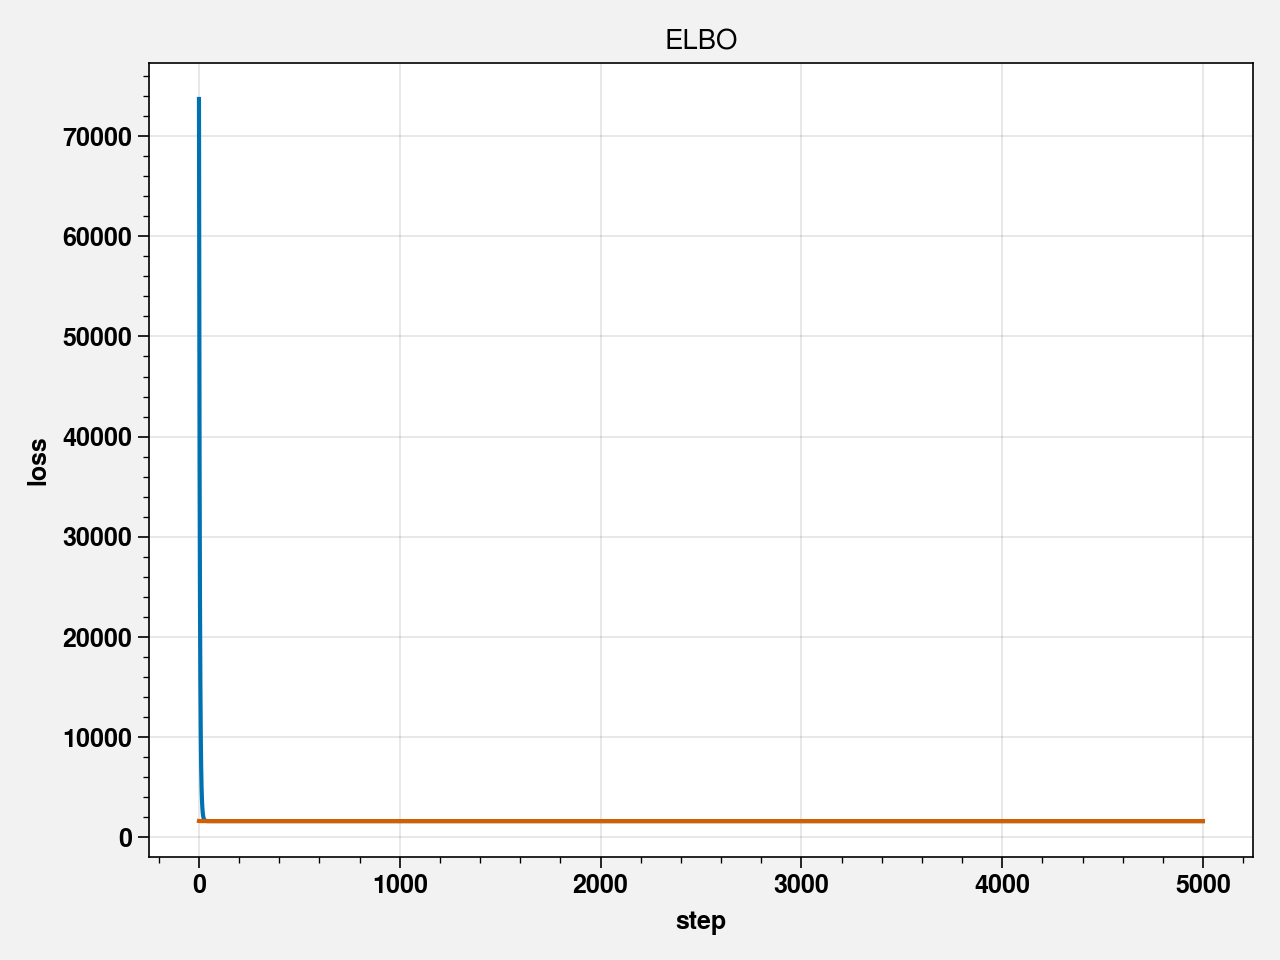

In [ ]:
def model42():
    mu = pyro.sample("mu", dist.Normal(tensor(178.), tensor(0.1)))
    sigma = pyro.sample("sigma", dist.Uniform(0, tensor(50.)))
    height = pyro.sample("height", dist.Normal(mu, sigma))
    return height 
    

def guide42():
    mu_param = pyro.param(
        "mu_param", tensor(140.)
    )
    sigma_param = pyro.param(
        "sigma_param", tensor(20.), constraint=constraints.positive
    )
    return pyro.sample("mu", dist.Delta(mu_param)), pyro.sample("sigma", dist.Delta(sigma_param))


conditioned42 = pyro.condition(model42, data={"height": tensor(howell2['height'], dtype=torch.float)})

pyro.clear_param_store()
svi = pyro.infer.SVI(
    model=conditioned42,
    guide=guide42,
    optim=pyro.optim.SGD({"lr": 0.001, "momentum": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)


num_steps = 5000
losses = [svi.step() for t in range(num_steps)]

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
print("mu42 = ", pyro.param("mu_param").item())
print("sigma42 = ", pyro.param("sigma_param").item())


guide42 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned42)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned42,
    guide=guide42,
    optim=pyro.optim.SGD({"lr": 0.001, "momentum": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
#svi.run()
losses = [svi.step() for t in range(num_steps)]

laplace_guide42 = guide42.laplace_approximation()
pred42 = pyro.infer.Predictive(laplace_guide42, num_samples=1000)
p_summary42 = summary(pred42.get_samples(), 0.945).loc[:, ["mu", "sigma"]]

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()

p_summary42

# Code 4.30

In [ ]:
def vcov(pred):
  mu = tensor(pred.get_samples()["mu"], dtype=torch.float)
  sigma = tensor(pred.get_samples()["sigma"], dtype=torch.float)
  t = torch.stack((mu, sigma), dim=1)
  t_mean = t.mean(0)
  t = t - t_mean 
  cov = torch.mm(torch.transpose(t, 0, 1), (t))*1/(t.shape[0]-1)
  cov = tensor(cov, dtype=torch.float)
  return cov
vcov(pred41)

tensor([[0.0103, 0.0018],
        [0.0018, 0.2181]])

# Code 4.31

In [ ]:
def cov2cor(cov):
  return cov / cov.diag().ger(cov.diag()).sqrt()

cov = vcov(pred41)
print(cov.diag())
print(cov2cor(cov))

tensor([0.0101, 0.2333])
tensor([[1.0000, 0.0302],
        [0.0302, 1.0000]])


# Code 4.32

In [ ]:
pred41_mu = tensor(pred41.get_samples()["mu"], dtype=torch.float)
pred41_sigma = tensor(pred41.get_samples()["sigma"], dtype=torch.float)

post = torch.stack((pred41_mu, pred41_sigma), dim=1)
post

tensor([[154.5693,   7.2724],
        [154.4774,   7.9250],
        [154.7430,   7.9293],
        ...,
        [154.5790,   7.0756],
        [154.6590,   7.2606],
        [154.5707,   7.9989]])

# Code 4.33

In [ ]:
p_summary = summary(pred41.get_samples(), 0.945).loc[:, ["mu", "sigma"]]
p_summary

,mu,sigma
mean,154.60869,7.720367
std,0.097480394,0.5012503
5.5%,154.45084,6.9692016
94.5%,154.76424,8.564913


# Code 4.34

In [ ]:
post = dist.MultivariateNormal(tensor([p_summary.loc['mean', 'mu'].tolist(), p_summary.loc['mean', 'sigma'].tolist()], dtype=torch.float32),
                               cov.float()).sample(torch.Size([10000]))


# Code 4.35

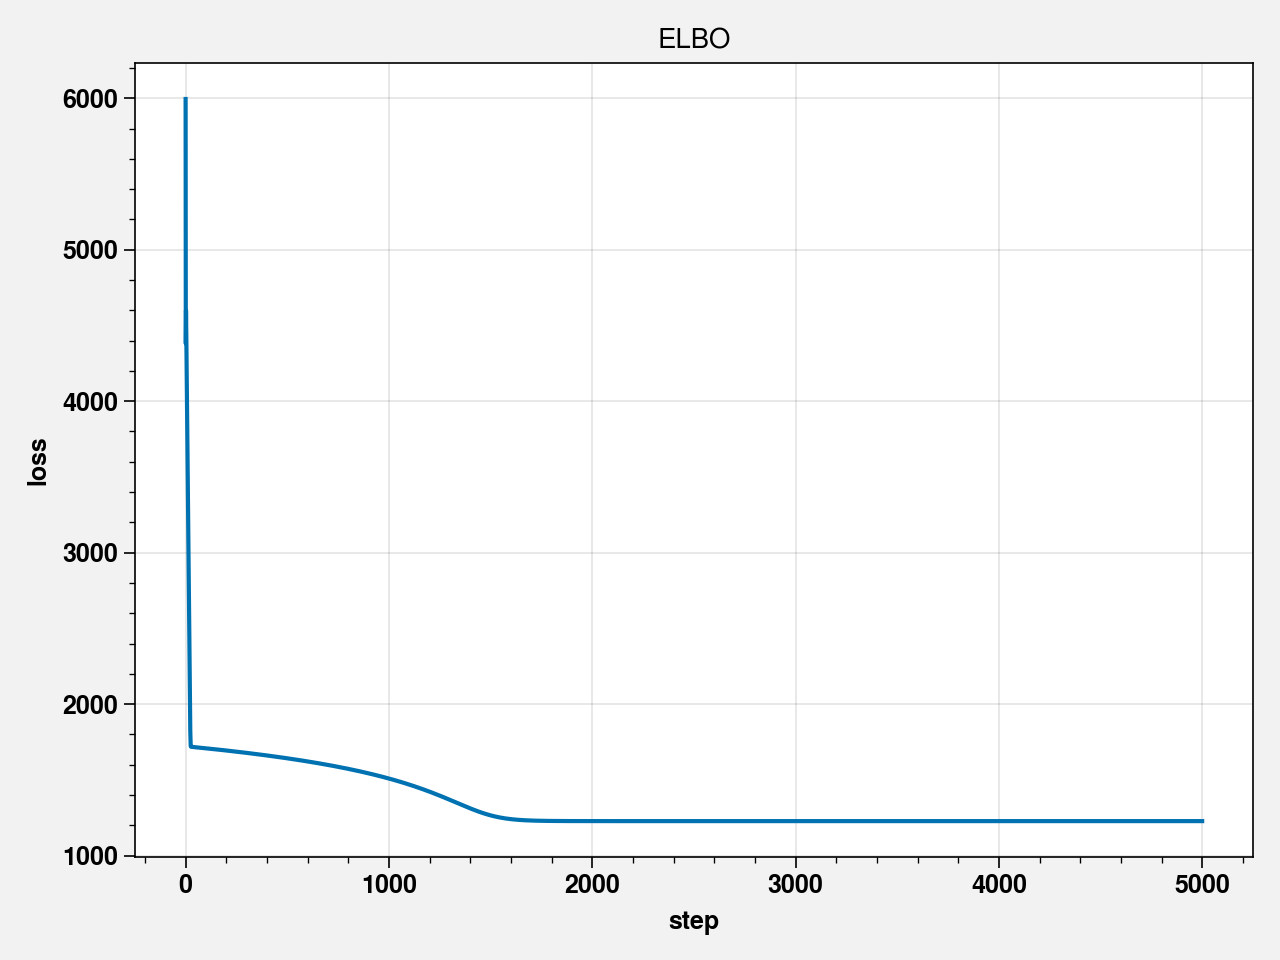

In [ ]:
def model41_logsigma():
    mu = pyro.sample("mu", dist.Normal(tensor(178.), tensor(20.)))
    logsigma = pyro.sample("logsigma", dist.Normal(tensor(2.), tensor(10.)))
    height = pyro.sample("height", dist.Normal(mu, logsigma.float().exp()))
    return height 

conditioned41_logsigma = pyro.condition(model41_logsigma, data={"height": tensor(howell2['height'], dtype=torch.float)})

guide41_logsigma = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned41_logsigma)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned41_logsigma,
    guide=guide41_logsigma,
    optim=pyro.optim.SGD({"lr": 0.001, "momentum": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step() for t in range(num_steps)]

laplace_guide41_logsigma = guide41_logsigma.laplace_approximation()
pred41_logsigma = pyro.infer.Predictive(laplace_guide41_logsigma, num_samples=1000)


plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()

# Code 4.36

In [ ]:
post = pred41_logsigma.get_samples()
sigma = torch.exp(post["logsigma"])
print(sigma.mean(), sigma.std())


tensor(7.7237, grad_fn=<MeanBackward0>) tensor(0.2832, grad_fn=<StdBackward0>)


# Code 4.37

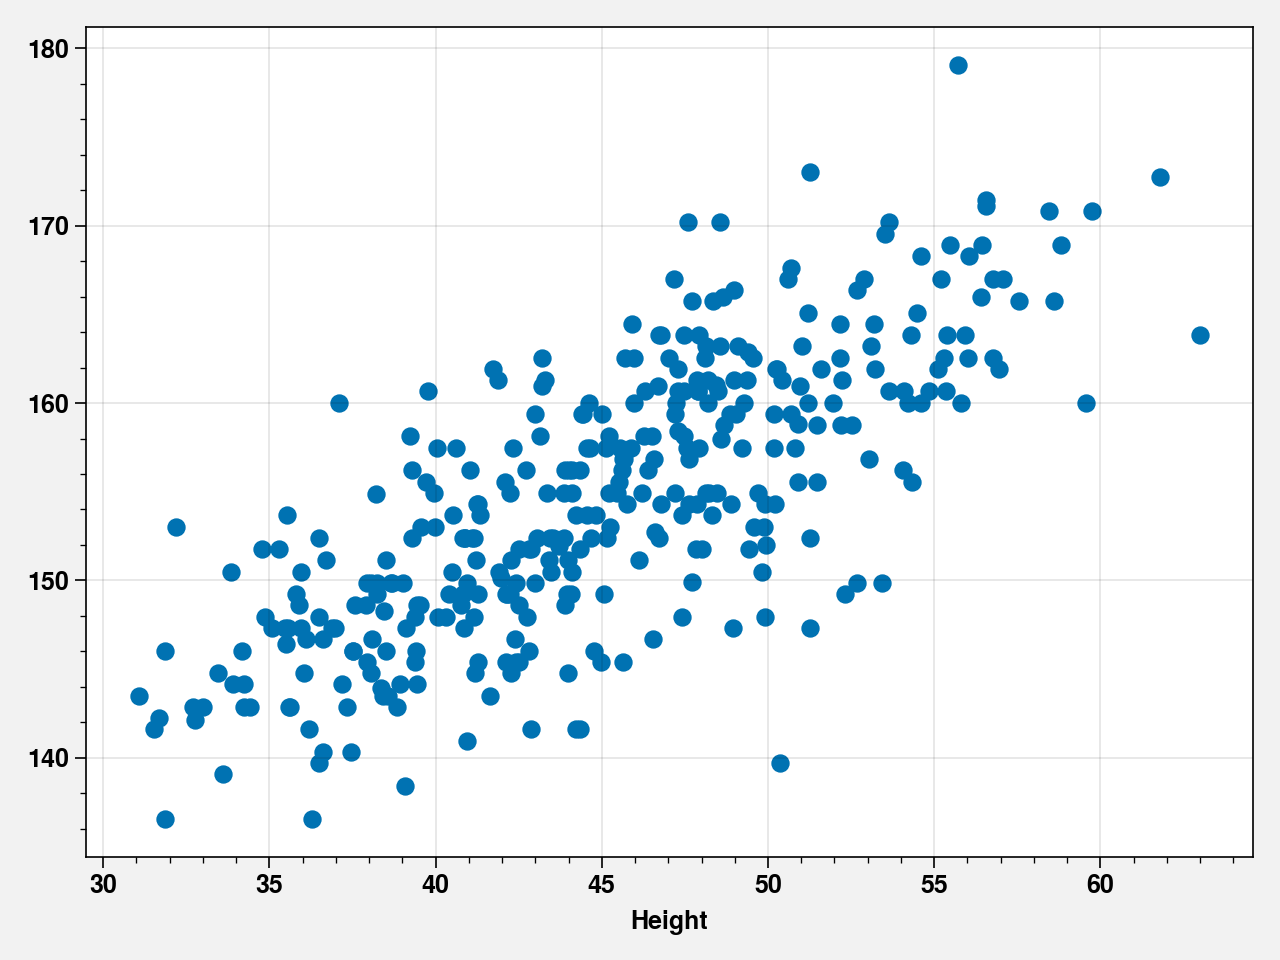

In [ ]:
fig, ax = plt.subplots()
ax.scatter(howell2['weight'], howell2['height'])
ax.set_xlabel('Weight')
ax.set_xlabel('Height')
fig.tight_layout()

# Code 4.38

a =  113.8954086303711
b =  0.9046812057495117
sigma =  5.071866035461426


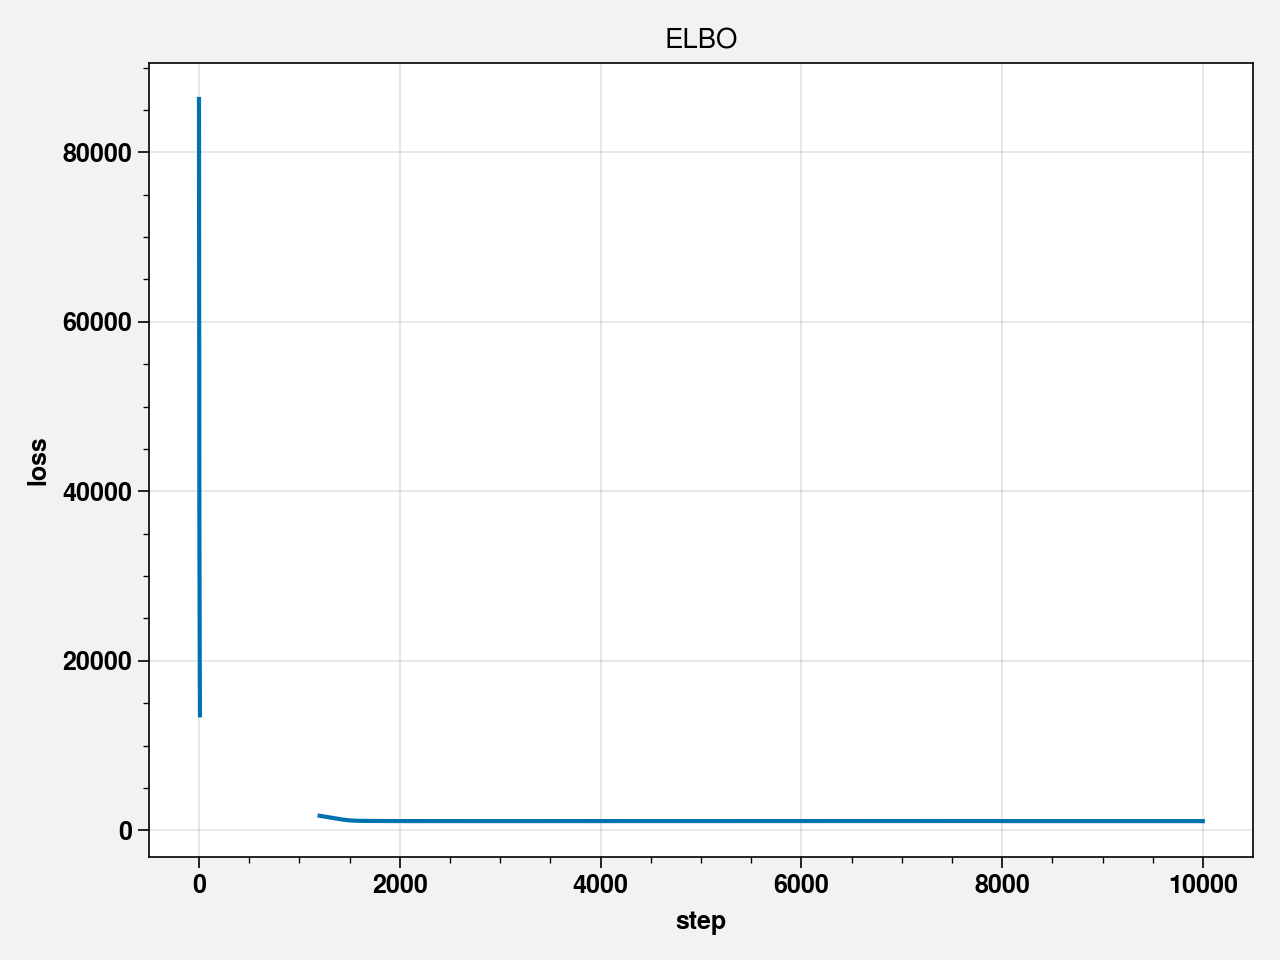

In [ ]:
def model43(weight):

  weight = weight.float()
  a = pyro.sample("a", dist.Normal(tensor(156.), tensor(100.)))
  b = pyro.sample("b", dist.Normal(tensor(0.), tensor(10.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(50.)))
  mu = a + b * weight

  height = pyro.sample("height", dist.Normal(mu, sigma))
  return height 

def guide43(weight):
  a_param = pyro.param("a_param", tensor(140.))
  b_param = pyro.param("b_param", tensor(10.))
  sigma_param = pyro.param("sigma_param", tensor(20.), constraint=constraints.positive)
  return (pyro.sample("a", dist.Delta(a_param)), pyro.sample("b", dist.Delta(b_param)), pyro.sample("sigma", dist.Delta(sigma_param)))

howell2_height = tensor(howell2['height'], dtype=torch.float)
howell2_weight = tensor(howell2['weight'], dtype=torch.float)

conditioned43 = pyro.condition(model43, data={"height": howell2_height})

pyro.clear_param_store()
svi = pyro.infer.SVI(
    model=conditioned43,
    guide=guide43,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 10000
losses = [svi.step(howell2_weight) for t in range(num_steps)]

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
print("a = ", pyro.param("a_param").item())
print("b = ", pyro.param("b_param").item())
print("sigma = ", pyro.param("sigma_param").item())

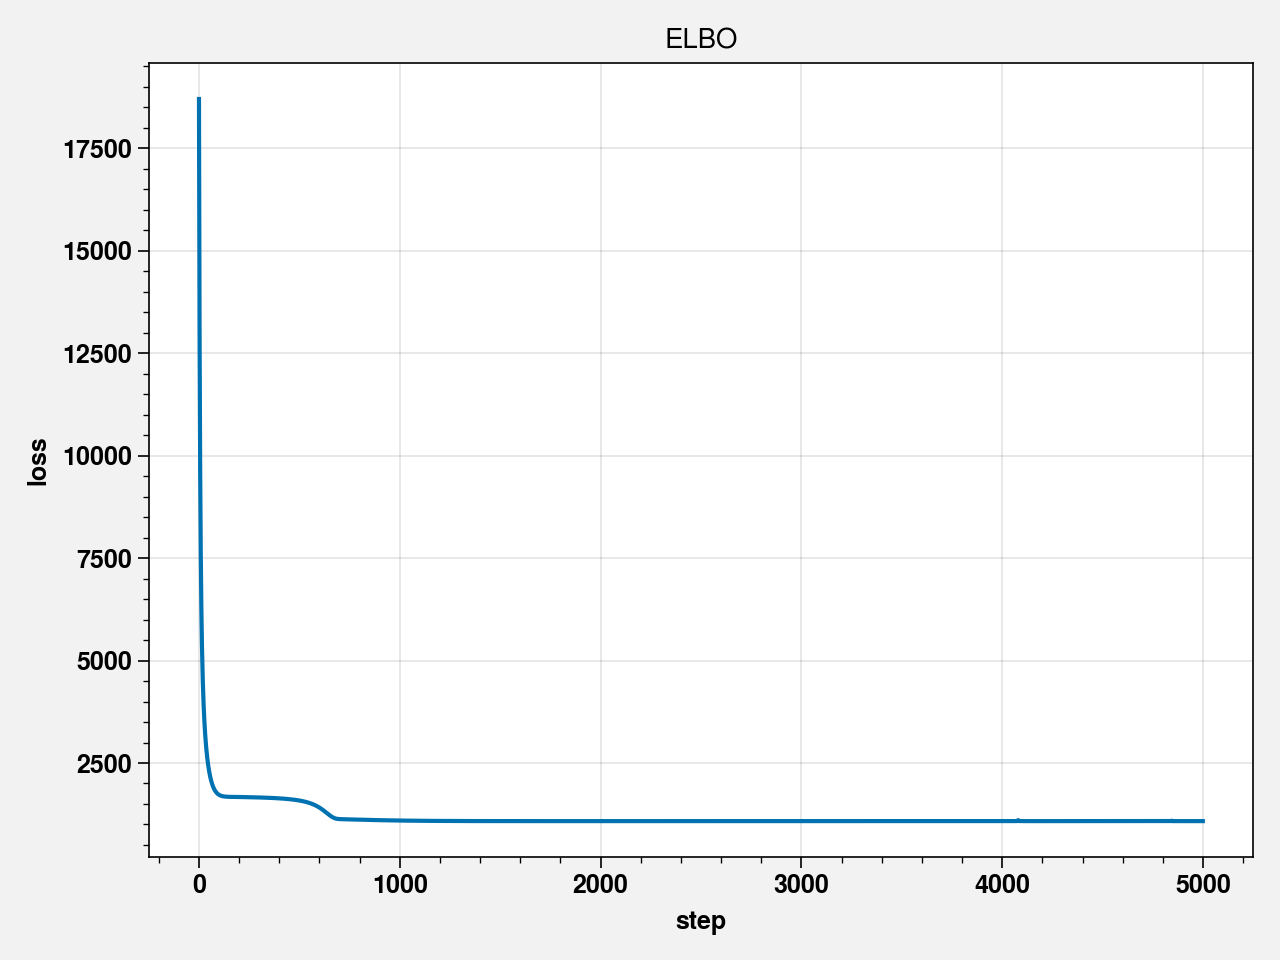

In [ ]:
guide43 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned43)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned43,
    guide=guide43,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(howell2_weight) for t in range(num_steps)]
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
laplace_guide43 = guide43.laplace_approximation(howell2_weight)
pred43 = pyro.infer.Predictive(laplace_guide43, num_samples=1000)

# Code 4.39


a =  113.8954086303711
b =  0.9046812057495117
sigma =  5.071866035461426


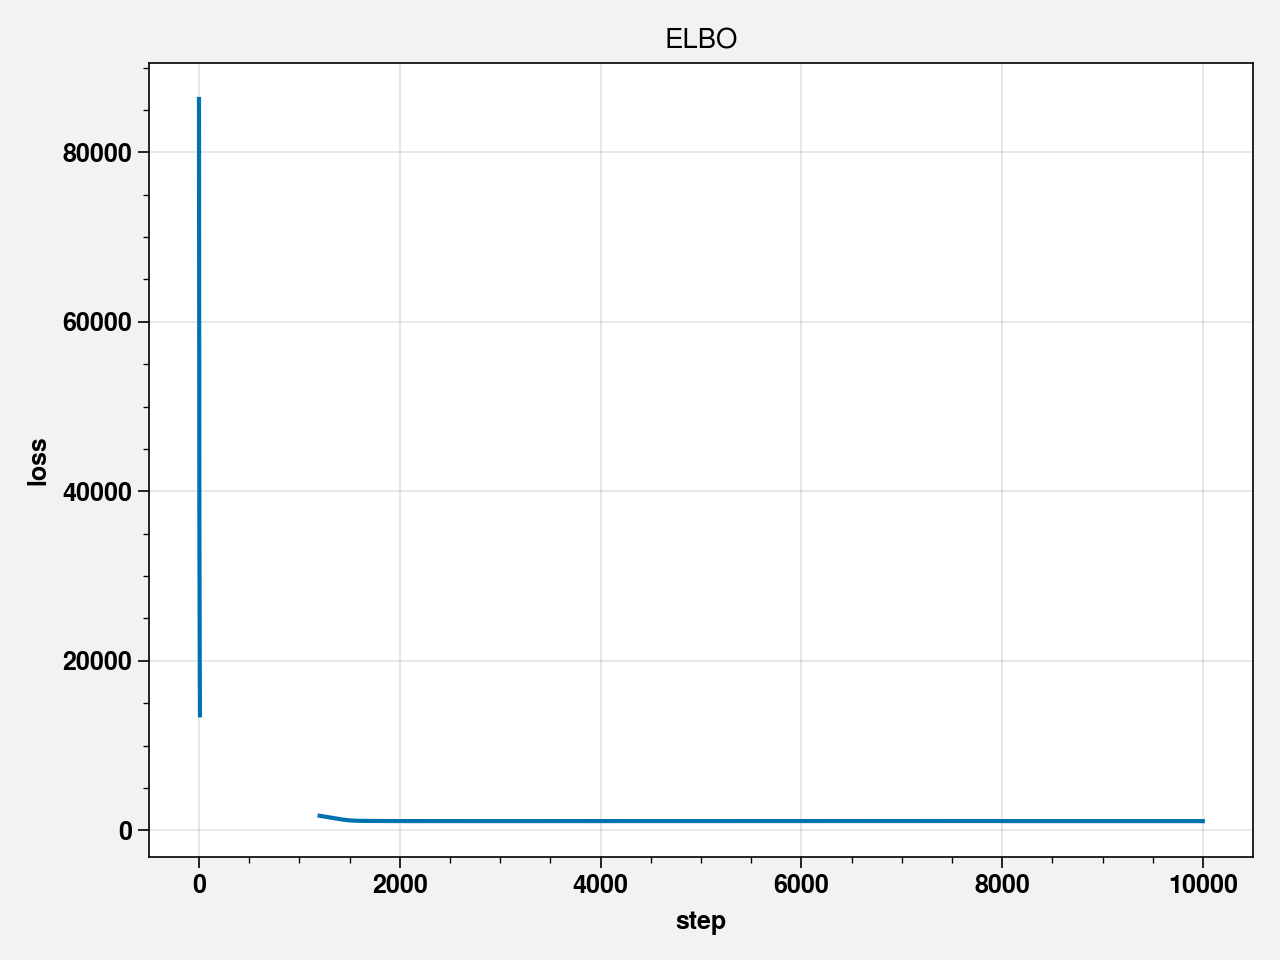

In [ ]:
def model43(weight):

  weight = weight.float()
  a = pyro.sample("a", dist.Normal(tensor(156.), tensor(100.)))
  b = pyro.sample("b", dist.Normal(tensor(0.), tensor(10.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(50.)))

  height = pyro.sample("height", dist.Normal(a + b * weight, sigma))
  return height 

def guide43(weight):
  a_param = pyro.param("a_param", tensor(140.))
  b_param = pyro.param("b_param", tensor(10.))
  sigma_param = pyro.param("sigma_param", tensor(20.), constraint=constraints.positive)
  return (pyro.sample("a", dist.Delta(a_param)), pyro.sample("b", dist.Delta(b_param)), pyro.sample("sigma", dist.Delta(sigma_param)))

howell2_height = tensor(howell2['height'], dtype=torch.float)
howell2_weight = tensor(howell2['weight'], dtype=torch.float)

conditioned43 = pyro.condition(model43, data={"height": howell2_height})

pyro.clear_param_store()
svi = pyro.infer.SVI(
    model=conditioned43,
    guide=guide43,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 10000
losses = [svi.step(howell2_weight) for t in range(num_steps)]

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
print("a = ", pyro.param("a_param").item())
print("b = ", pyro.param("b_param").item())
print("sigma = ", pyro.param("sigma_param").item())

# Code 4.40

,_AutoMultivariateNormal_latent,a,b,sigma
mean,"[113.881485, 0.9048469, -2.179848]",113.88147,0.90484685,5.0821924
std,"[1.866467, 0.04134287, 0.043607295]",1.866467,0.04134287,0.19905195
5.0%,"[110.85748, 0.8348641, -2.2518675]",110.85748,0.8348641,4.759425
95.0%,"[116.87696, 0.971757, -2.1083095]",116.87696,0.971757,5.4145904


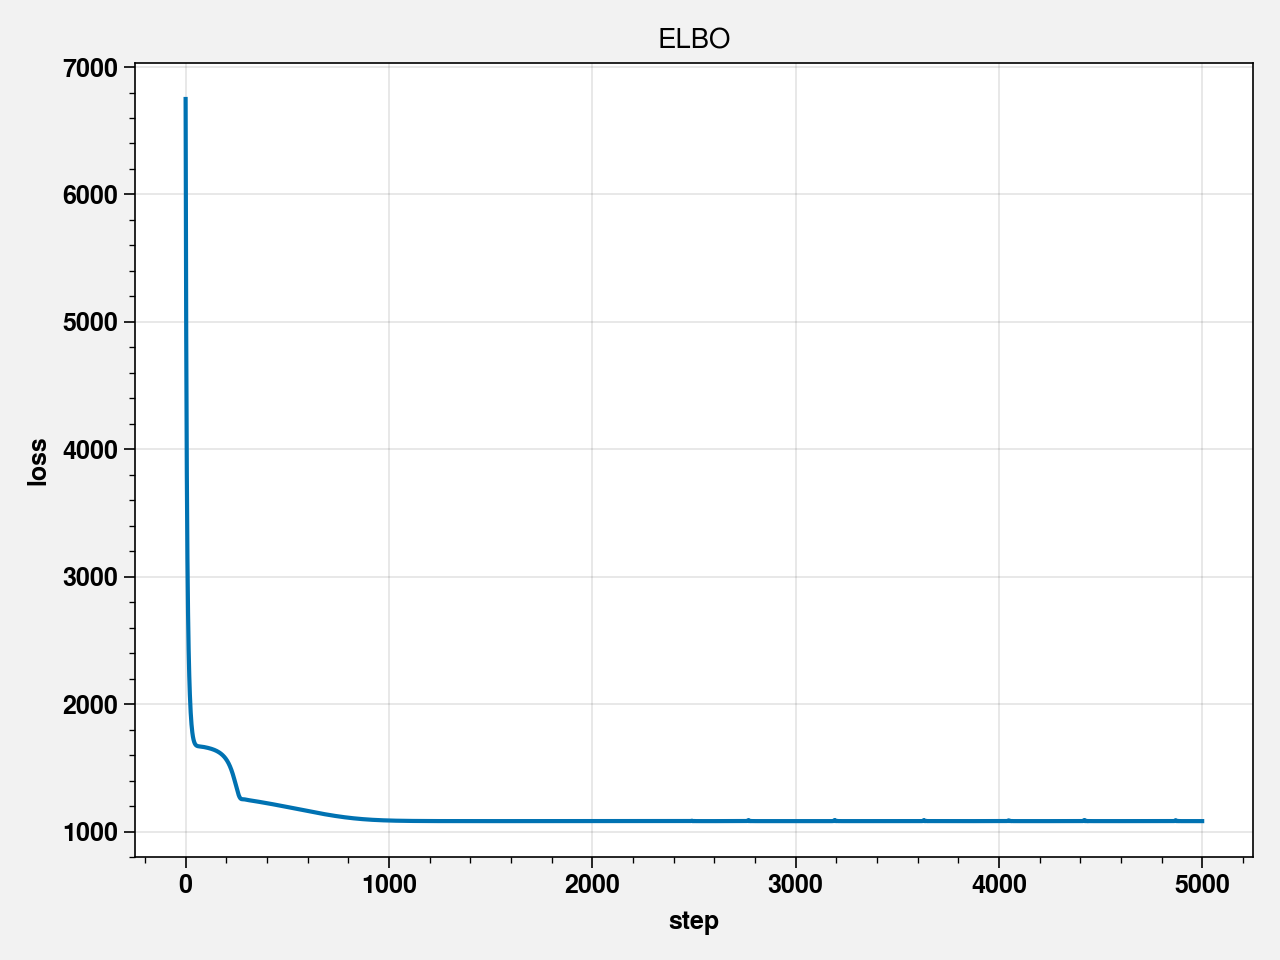

In [ ]:
def model43(weight):

  weight = weight.float()
  a = pyro.sample("a", dist.Normal(tensor(178.), tensor(100.)))
  b = pyro.sample("b", dist.Normal(tensor(0.), tensor(10.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(50.)))

  height = pyro.sample("height", dist.Normal(a + b * weight, sigma))
  return height 

def guide43(weight):
  a_param = pyro.param("a_param", tensor(140.))
  b_param = pyro.param("b_param", tensor(10.))
  sigma_param = pyro.param("sigma_param", tensor(20.), constraint=constraints.positive)
  return (pyro.sample("a", dist.Delta(a_param)), pyro.sample("b", dist.Delta(b_param)), pyro.sample("sigma", dist.Delta(sigma_param)))

howell2_height = tensor(howell2['height'], dtype=torch.float)
howell2_weight = tensor(howell2['weight'], dtype=torch.float)

conditioned43 = pyro.condition(model43, data={"height": howell2_height})
pyro.clear_param_store()
svi = pyro.infer.SVI(
    model=conditioned43,
    guide=guide43,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)


num_steps = 5000
losses = [svi.step(howell2_weight) for t in range(num_steps)]
coef_m43_a = pyro.param("a_param").item()
coef_m43_b = pyro.param("b_param").item()
coef_m43_sigma = pyro.param("sigma_param").item()



guide43 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned43)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned43,
    guide=guide43,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(howell2_weight) for t in range(num_steps)]
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
laplace_guide43 = guide43.laplace_approximation(howell2_weight)
pred43 = pyro.infer.Predictive(laplace_guide43, num_samples=1000)
summary(pred43.get_samples())#[["mu", "sigma"]]

# Code 4.41

In [ ]:
def summary(samples, prob=0.95):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0).data.numpy(),
            "std": torch.std(v, 0).data.numpy(),
            "{:.1f}%".format(100 * (1 - prob)): v.kthvalue(
                int(len(v) * (1 - prob)), dim=0
            )[0].data.numpy(),
            "{:.1f}%".format(100 * prob): v.kthvalue(int(len(v) * prob), dim=0)[
                0
            ].data.numpy(),
        }
    return pd.DataFrame(site_stats)

def vcov_gen(samples):
  cols = list(samples.keys())
  t = [samples[cols[1]]]
  for k in cols[2:]:
    y = samples[k]
    t.append(y)
  t = torch.stack(t, dim=1)
  t_mean = t.mean(0)
  t = t - t_mean 
  cov = torch.mm(torch.transpose(t, 0, 1), (t))*1/(t.shape[0]-1)
  cov = tensor(cov, dtype=torch.float)
  return cov

cov = vcov_gen(pred43.get_samples())
print(cov2cor(cov))
summary(pred43.get_samples())

tensor([[ 1.0000, -0.9910,  0.0055],
        [-0.9910,  1.0000, -0.0049],
        [ 0.0055, -0.0049,  1.0000]])


,_AutoMultivariateNormal_latent,a,b,sigma
mean,"[113.92779, 0.90387636, -2.1774142]",113.92786,0.9038759,5.0932956
std,"[1.9352714, 0.042408817, 0.043513753]",1.9352714,0.042408817,0.19933166
5.0%,"[110.83859, 0.82878053, -2.2503507]",110.83859,0.82878053,4.765961
95.0%,"[117.29115, 0.9714027, -2.104298]",117.29115,0.9714027,5.4339886


# Code 4.42

In [ ]:
howell2['weight_centered'] = howell2['weight'] - howell2['weight'].mean()

# Code 4.43

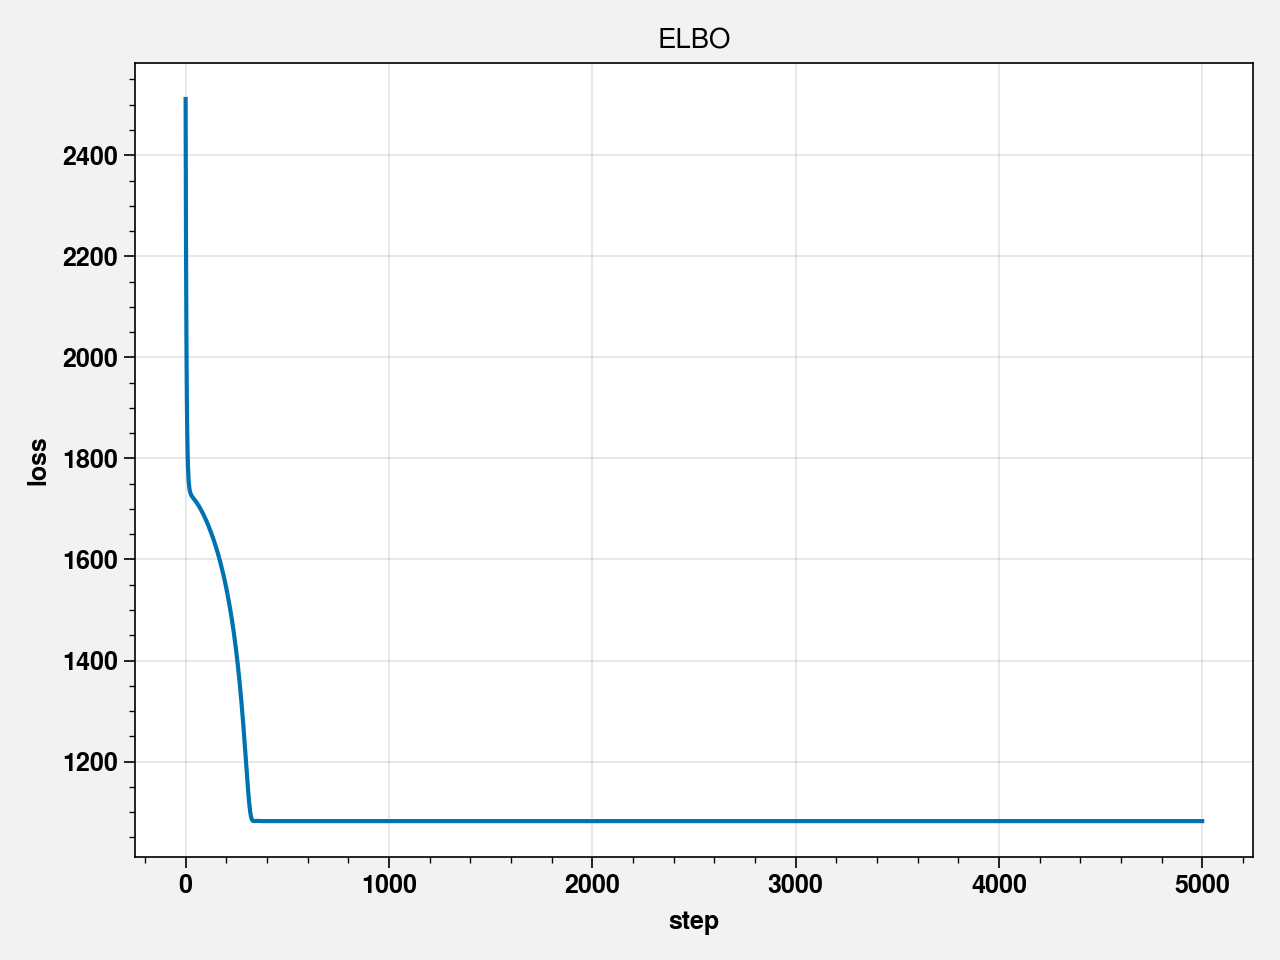

In [ ]:
def model44(weight_centered):

  weight_centered = weight_centered.float()
  a = pyro.sample("a", dist.Normal(tensor(178.), tensor(100.)))
  b = pyro.sample("b", dist.Normal(tensor(0.), tensor(10.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(50.)))

  height = pyro.sample("height", dist.Normal(a + b * weight_centered, sigma))
  return height 

def guide44(weight_centered):
  a_param = pyro.param("a_param", tensor(140.))
  b_param = pyro.param("b_param", tensor(10.))
  sigma_param = pyro.param("sigma_param", tensor(20.), constraint=constraints.positive)
  return (pyro.sample("a", dist.Delta(a_param)), pyro.sample("b", dist.Delta(b_param)), 
          pyro.sample("sigma", dist.Delta(sigma_param)))

howell2_height = tensor(howell2['height'], dtype=torch.float)
howell2_weight_centered = tensor(howell2['weight_centered'], dtype=torch.float)

conditioned44 = pyro.condition(model44, data={"height": howell2_height})
pyro.clear_param_store()
svi = pyro.infer.SVI(
    model=conditioned44,
    guide=guide44,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)


num_steps = 5000
losses = [svi.step(howell2_weight_centered) for t in range(num_steps)]
coef_m44_a = pyro.param("a_param").item()
coef_m44_b = pyro.param("b_param").item()
coef_m44_sigma = pyro.param("sigma_param").item()


guide44 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned44)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned44,
    guide=guide44,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(howell2_weight_centered) for t in range(num_steps)]
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
laplace_guide44 = guide44.laplace_approximation(howell2_weight_centered)
pred44 = pyro.infer.Predictive(laplace_guide44, num_samples=1000)

# Code 4.44

In [ ]:
cov = vcov_gen(pred44.get_samples())
print(cov2cor(cov))
summary(pred44.get_samples())

tensor([[ 1.0000, -0.0264,  0.0438],
        [-0.0264,  1.0000, -0.0251],
        [ 0.0438, -0.0251,  1.0000]])


,_AutoMultivariateNormal_latent,a,b,sigma
mean,"[154.60448, 0.9050131, -2.1805956]",154.60442,0.9050131,5.0782866
std,"[0.27103165, 0.042811833, 0.04034819]",0.27103165,0.042811833,0.18406394
5.0%,"[154.15924, 0.83221877, -2.246851]",154.15924,0.83221877,4.7810717
95.0%,"[155.04999, 0.9744703, -2.1168478]",155.04999,0.9744703,5.3735027


# Code 4.45

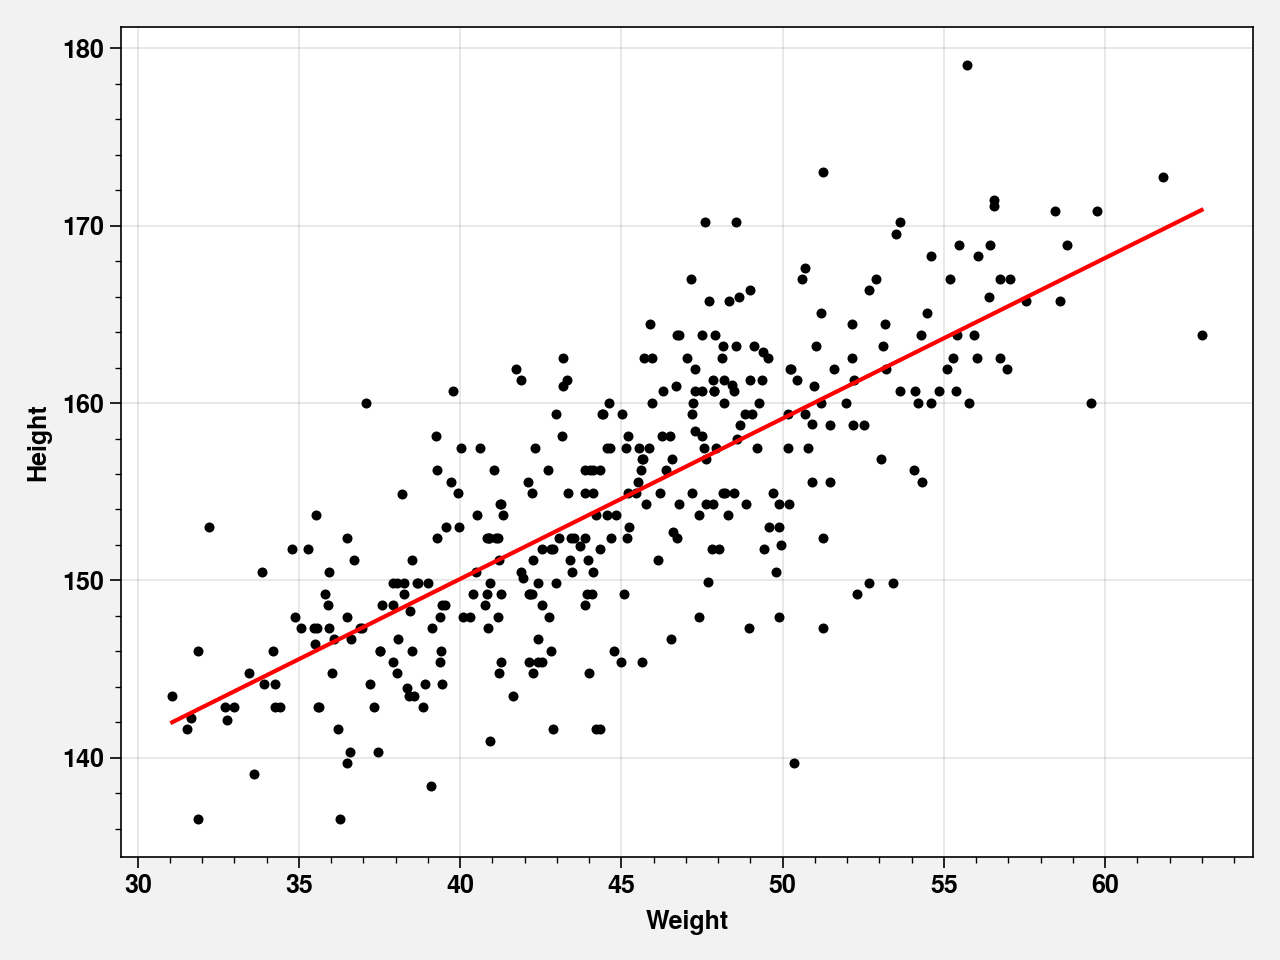

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x=howell2['weight'], y=howell2['height'], c='k', marker='.')
ax.plot(howell2['weight'].sort_values().unique(), howell2['weight'].sort_values().unique()*coef_m43_b + coef_m43_a, c='r')
ax.set_xlabel('Weight')
ax.set_ylabel('Height')
fig.tight_layout()

# Code 4.46

In [ ]:
post = pred43.get_samples()

# Code 4.47



In [ ]:
post

{'_AutoMultivariateNormal_latent': tensor([[114.1417,   0.8448,  -2.2523],
         [113.7764,   0.9718,  -2.1140],
         [113.6371,   0.8523,  -2.2056],
         ...,
         [113.8768,   0.9067,  -2.1677],
         [113.6774,   0.9603,  -2.1650],
         [114.7714,   0.9336,  -2.0775]], grad_fn=<ViewBackward>),
 'a': tensor([114.1417, 113.7764, 113.6371, 113.4627, 113.8561, 113.8759, 114.0705,
         113.8974, 113.9260, 113.9124, 114.4092, 113.3538, 113.8284, 113.3768,
         114.0937, 113.7870, 113.9814, 113.9841, 114.2106, 113.7158, 113.1776,
         113.3713, 113.9151, 113.5330, 113.9986, 113.8084, 113.7561, 113.8010,
         113.3781, 114.0362, 113.8035, 114.1163, 113.8056, 114.1140, 114.1226,
         114.1142, 113.9531, 113.7217, 113.4743, 113.6876, 114.4003, 114.0517,
         113.6276, 114.0897, 114.0033, 113.9235, 114.3421, 113.8833, 113.8892,
         113.6062, 113.3754, 113.3741, 113.6971, 113.7880, 113.9177, 114.1148,
         113.9093, 113.5020, 114.0530, 113.

# Code 4.48


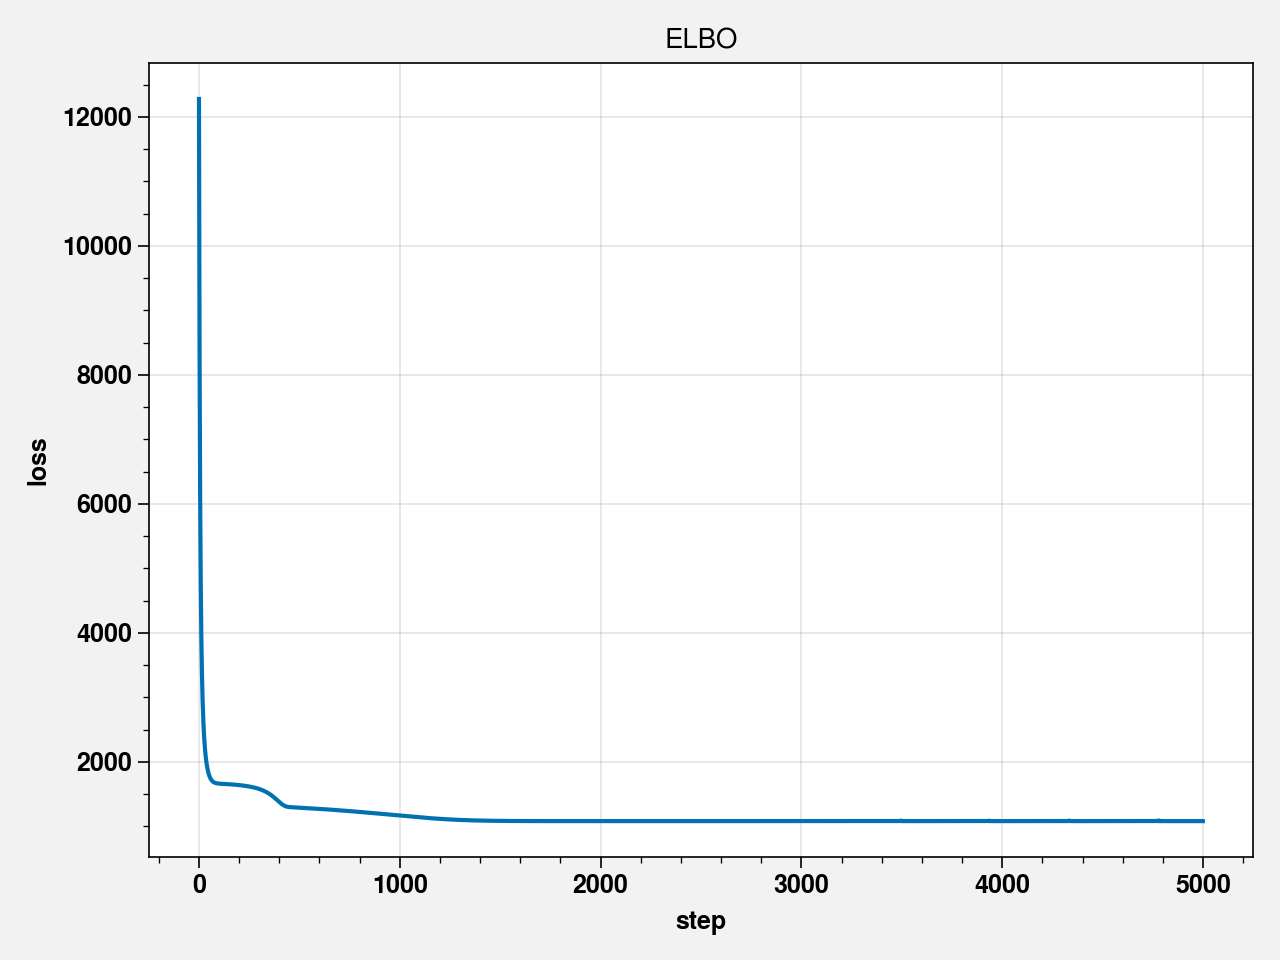

In [ ]:
N = 10
dN = howell2.iloc[:N]

def modelN(weight_centered):

  weight_centered = weight_centered.float()
  a = pyro.sample("a", dist.Normal(tensor(178.), tensor(100.)))
  b = pyro.sample("b", dist.Normal(tensor(0.), tensor(10.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(50.)))

  height = pyro.sample("height", dist.Normal(a + b * weight_centered, sigma))
  return height 


howell2_height = tensor(howell2['height'], dtype=torch.float)
howell2_weight = tensor(howell2['weight'], dtype=torch.float)

conditionedN = pyro.condition(modelN, data={"height": howell2_height})
guideN = pyro.infer.autoguide.AutoLaplaceApproximation(conditionedN)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditionedN,
    guide=guideN,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(howell2_weight) for t in range(num_steps)]
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
laplace_guideN = guideN.laplace_approximation(howell2_weight)
predN = pyro.infer.Predictive(laplace_guideN, num_samples=1000)

# Code 4.49



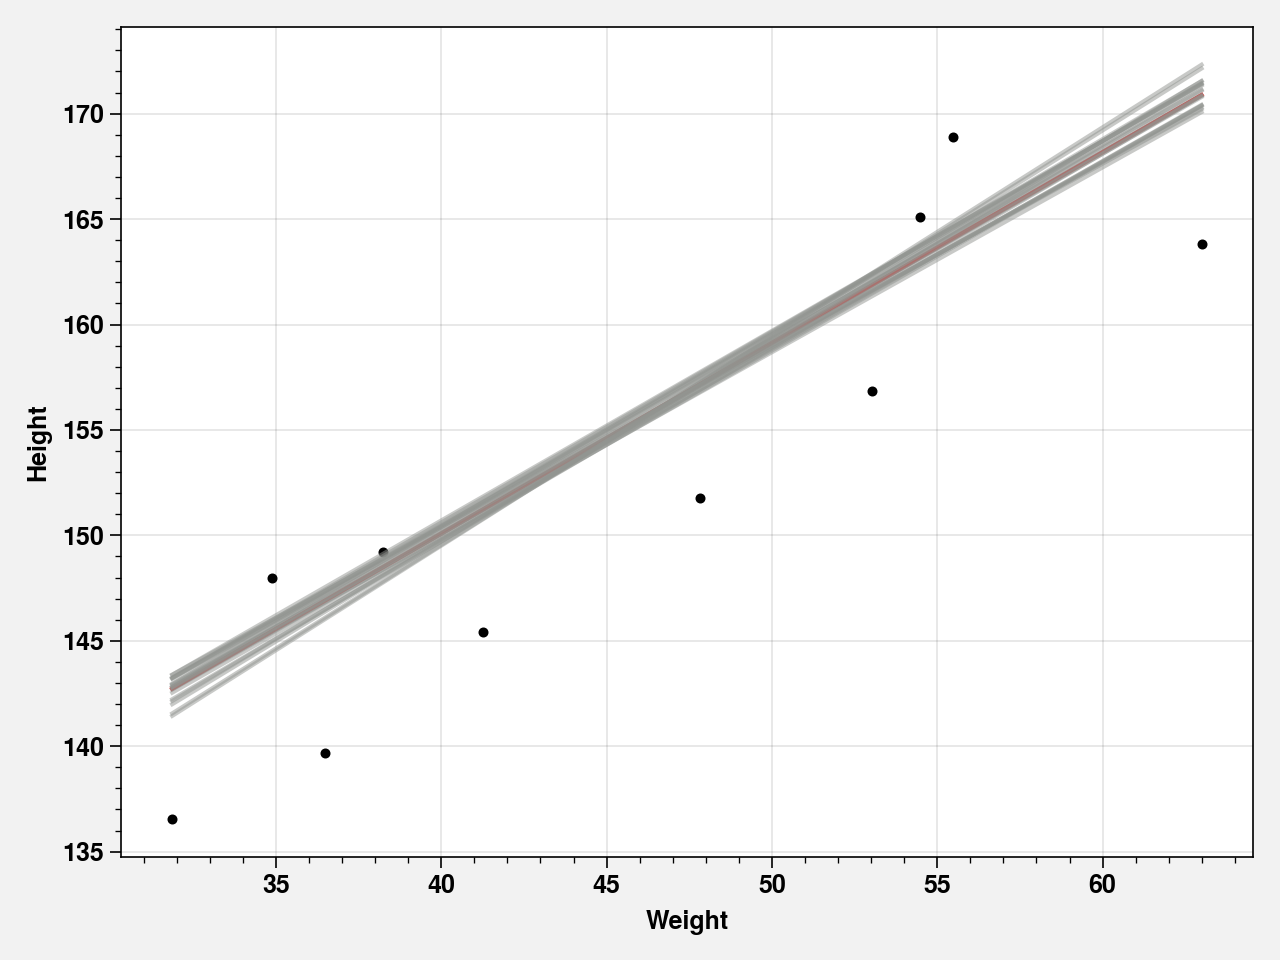

In [ ]:
post = predN.get_samples()


fig, ax = plt.subplots()
ax.scatter(x=dN['weight'], y=dN['height'], c='k', marker='.')
ax.plot(dN['weight'].sort_values().unique(), 
        dN['weight'].sort_values().unique()*coef_m43_b + coef_m43_a,
        c='r')
x = torch.linspace(dN['weight'].min(), dN['weight'].max(), 100)
for i in range(20):
  b = post["b"].detach()
  a = post["a"].detach()
  ax.plot(x, b[i]*x+a[i], alpha=.5, color='gray')
ax.set_xlabel('Weight')
ax.set_ylabel('Height')
fig.tight_layout()

# Code 4.50

In [ ]:
mu_at_50 = post["a"].detach() + post["b"].detach() * 50

# Code 4.51

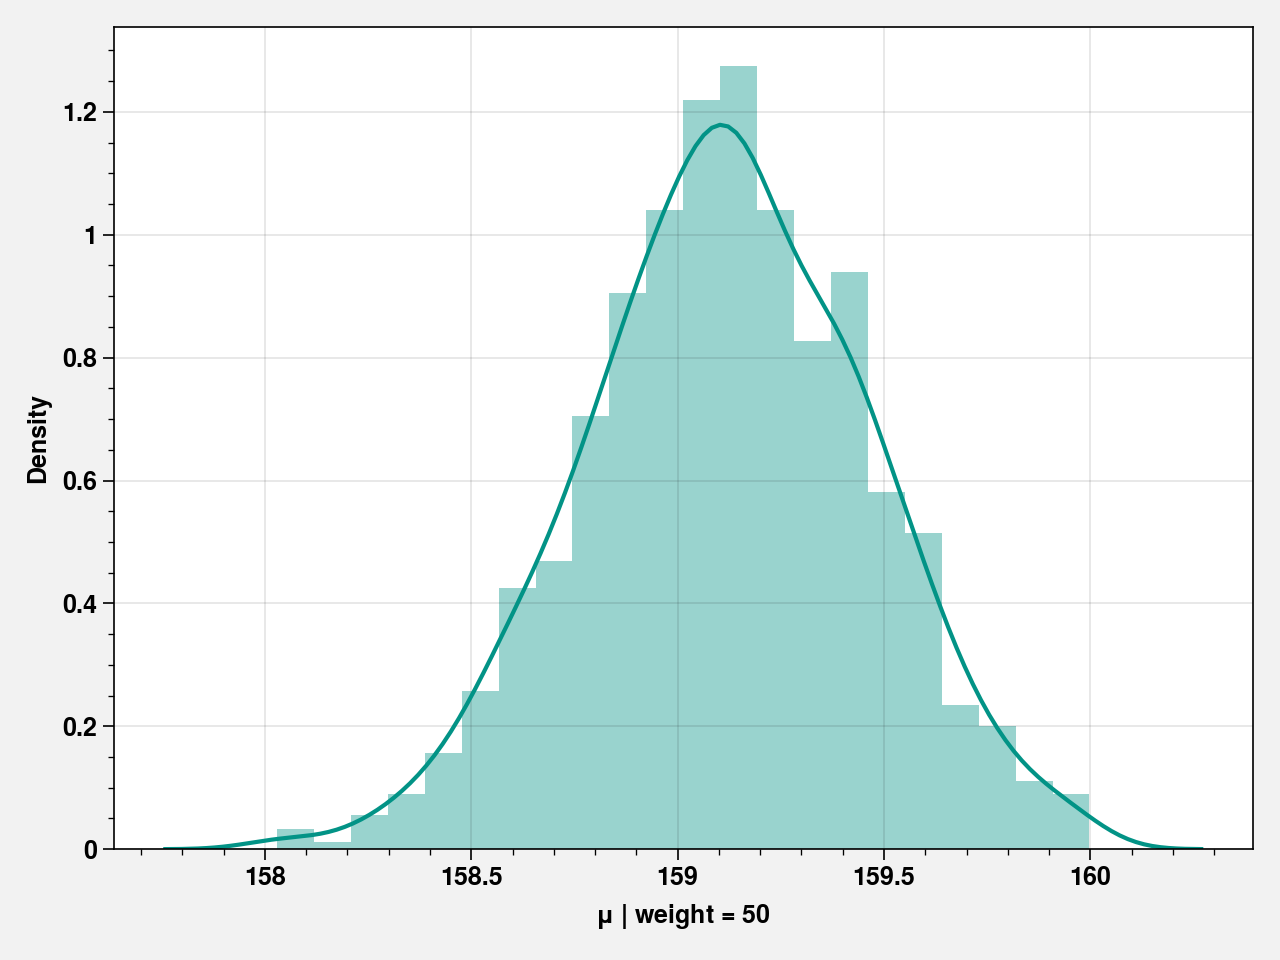

In [ ]:
fig, ax = plt.subplots()
sns.distplot(mu_at_50.numpy(), ax=ax, color='teal')
ax.set_xlabel(r'$\mu$ | weight = 50')
ax.set_ylabel('Density')
fig.tight_layout()

# Code 4.52

In [ ]:
stats.hpdi(mu_at_50, prob=0.89)

tensor([158.5554, 159.6319])

In [ ]:
howell2.shape

(352, 5)

In [ ]:
pred43.get_vectorized_trace()

# Code 4.53

In [ ]:
def link(laplace_guide, data, num_samples):
  pred = pyro.infer.Predictive(laplace_guide, num_samples=num_samples)
  samples = pred.get_samples()
  mu = samples["b"].detach().reshape((num_samples,1))*data.T.reshape(1, data.shape[0]) + samples["a"].detach().reshape((num_samples,1))
  return mu

mux = link(laplace_guide43, howell2_weight, 1000)
mux[:5, 0]

tensor([157.4199, 156.8046, 157.1543, 156.9337, 157.5259])

# Code 4.54

In [ ]:
weight_seq = torch.arange(25., 71., step=1)
mu = link(laplace_guide43, weight_seq, 1000)

# Code 4.55

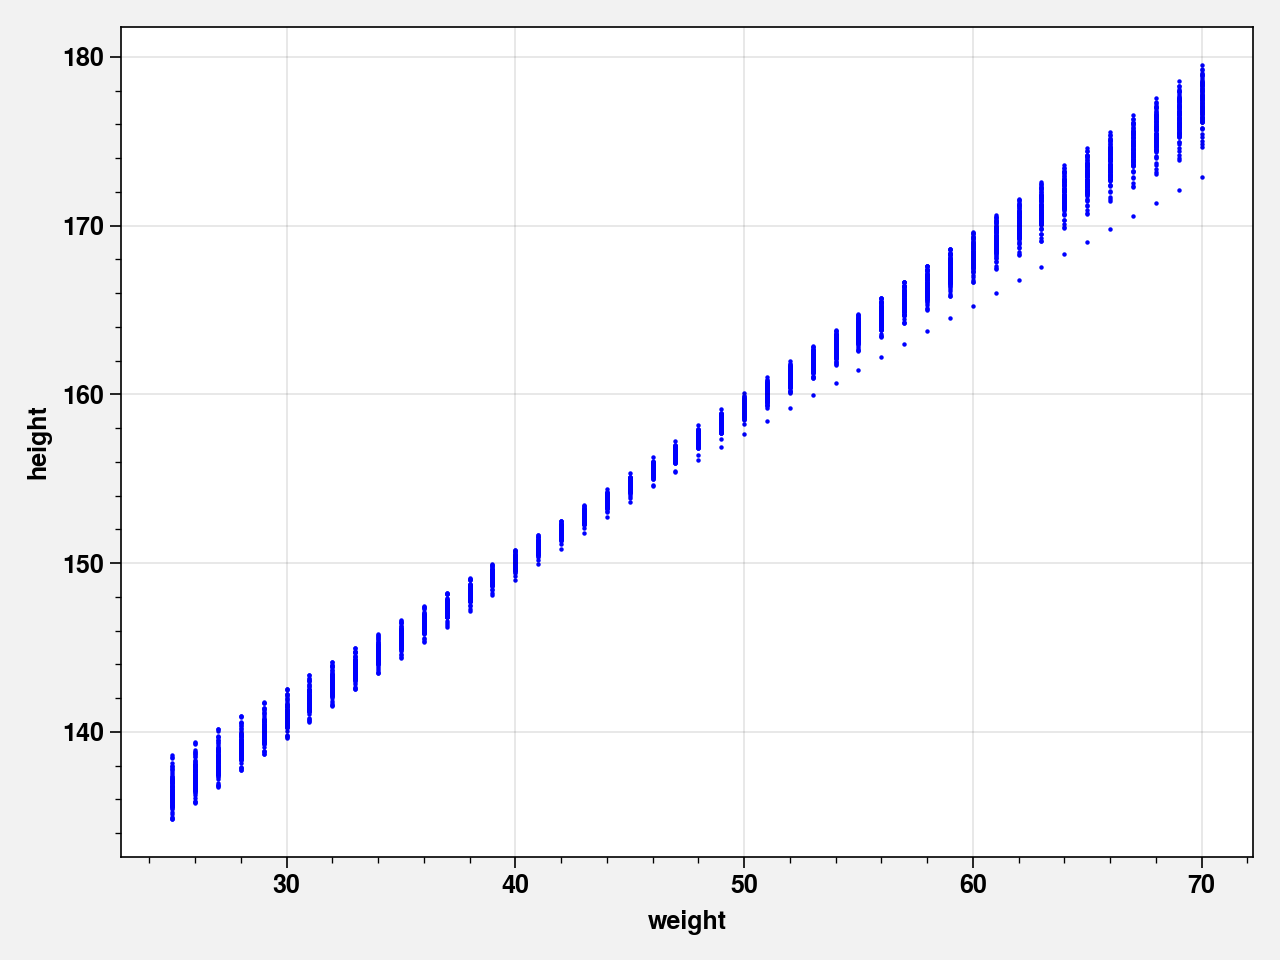

In [ ]:
fig, ax = plt.subplots()
#ax.plot(howell2['weight'], howell2['height'])
for i in range(100):
  ax.scatter(weight_seq, mu[i], color='blue', s=1)
ax.set_xlabel('weight')
ax.set_ylabel('height')
fig.tight_layout()

# Code 4.56

In [ ]:
mu_mean = mu.mean(0)
mu_hpdi = stats.hpdi(mu, dim=0, prob=0.89)

# Code 4.57


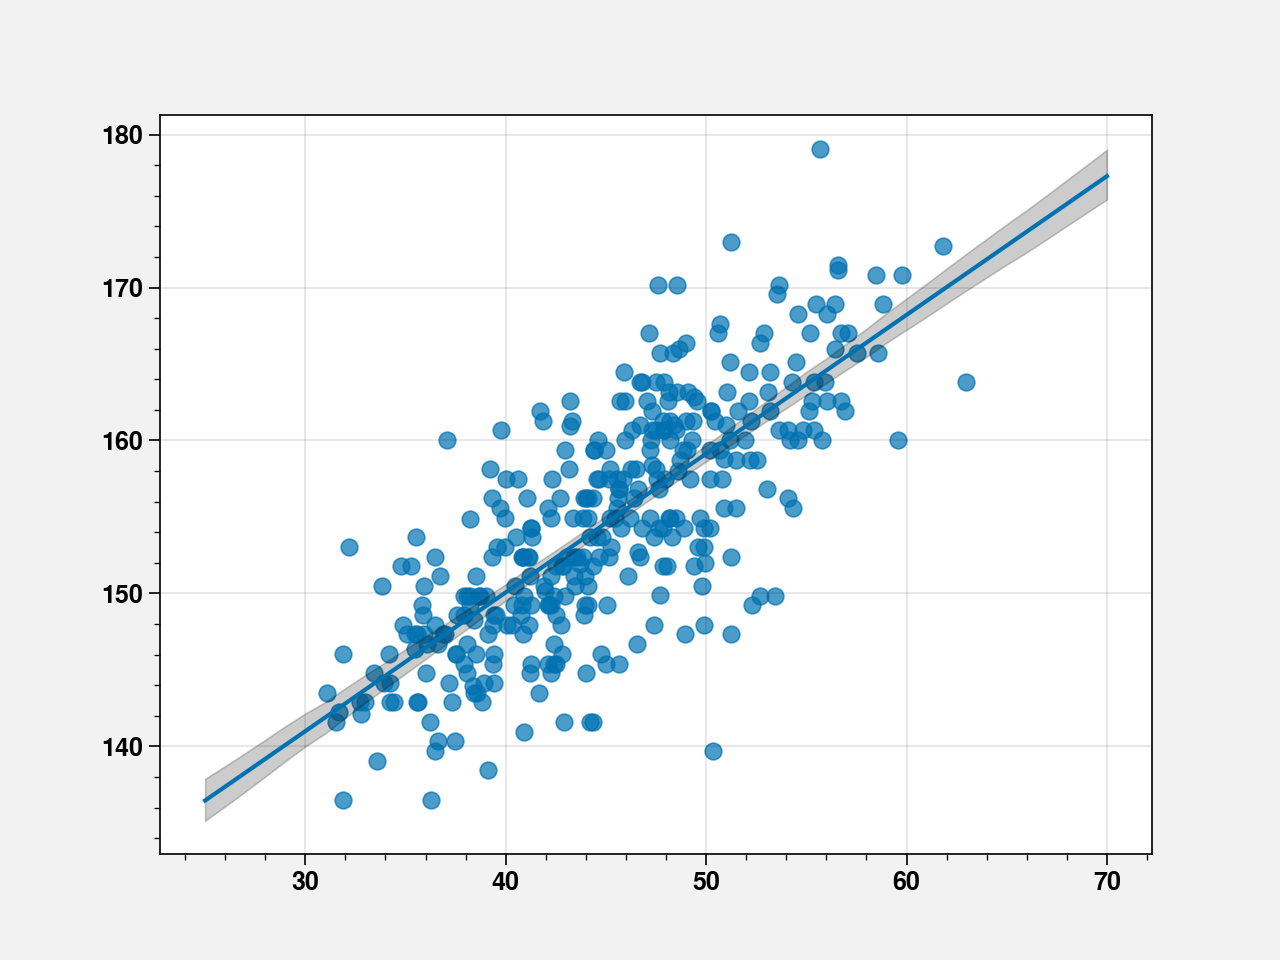

In [ ]:
fig, ax = plt.subplots()
ax.scatter(howell2['weight'], howell2['height'], alpha=0.7)
ax.plot(weight_seq, mu_mean)
ax.fill_between(weight_seq, mu_hpdi[0], mu_hpdi[1], color="k", alpha=0.2)

# Code 4.58

In [ ]:
post = pred43.get_samples()

weight_seq = torch.arange(25., 71., step=1)
mu = post["b"].detach().reshape((1000,1))*weight_seq.T.reshape(1, weight_seq.shape[0]) + post["a"].detach().reshape((1000,1))
mu_mean = mu.mean(0)
mu_hpdi = stats.hpdi(mu, dim=0, prob=0.89)

In [ ]:
mu_mean.shape

torch.Size([46])

# Code 4.59



In [ ]:
def sim(pred, data, num_samples=1000):
  samples = pred.get_samples()
  mu = samples["b"].detach().reshape((num_samples,1))*data.T.reshape(1, data.shape[0]) + samples["a"].detach().reshape((num_samples,1))
  print(mu.shape)
  sigma = samples["sigma"].reshape(num_samples,1)
  height_sampled = dist.Normal(mu, 
                               sigma).sample()
  return height_sampled

sim_height = sim(pred43, weight_seq)
sim_height.shape

torch.Size([1000, 46])


torch.Size([1000, 46])

# Code 4.60

In [ ]:
height_PI = stats.pi(sim_height, prob=0.89, dim=0)
height_PI.shape

torch.Size([2, 46])

# Code 4.61

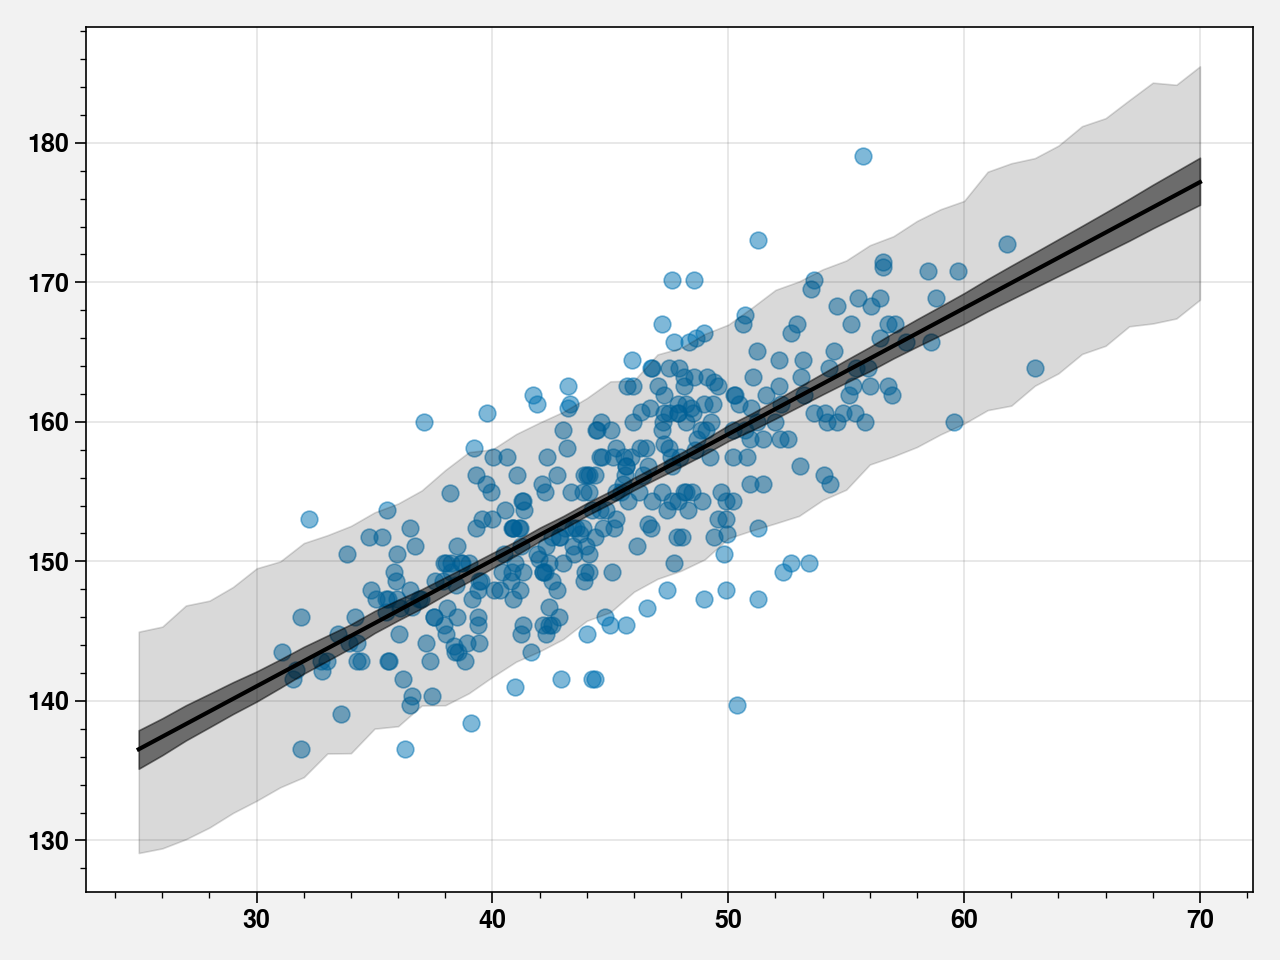

In [ ]:
# plot raw data
fig, ax = plt.subplots()
ax.scatter(howell2["weight"], howell2["height"], alpha=0.5)
ax.plot(weight_seq, mu_mean, color="k")
ax.fill_between(weight_seq, mu_hpdi[0], mu_hpdi[1], color="k", alpha=0.5)
ax.fill_between(weight_seq, height_PI[0].detach().numpy(), height_PI[1].detach().numpy(), color="k", alpha=0.15);
fig.tight_layout()

# Code 4.62

In [ ]:
sim_height = sim(pred43, weight_seq)
height_PI = stats.pi(sim_height, prob=0.89, dim=0)


torch.Size([1000, 46])


# Code 4.63

In [ ]:
# skip

# Code 4.64

In [ ]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0
542,71.120,8.051258,0.0,1


# Code 4.65

In [ ]:
howell['weight_s'] = (howell['weight']-howell['weight'].mean())/howell['weight'].std()

# Code 4.66


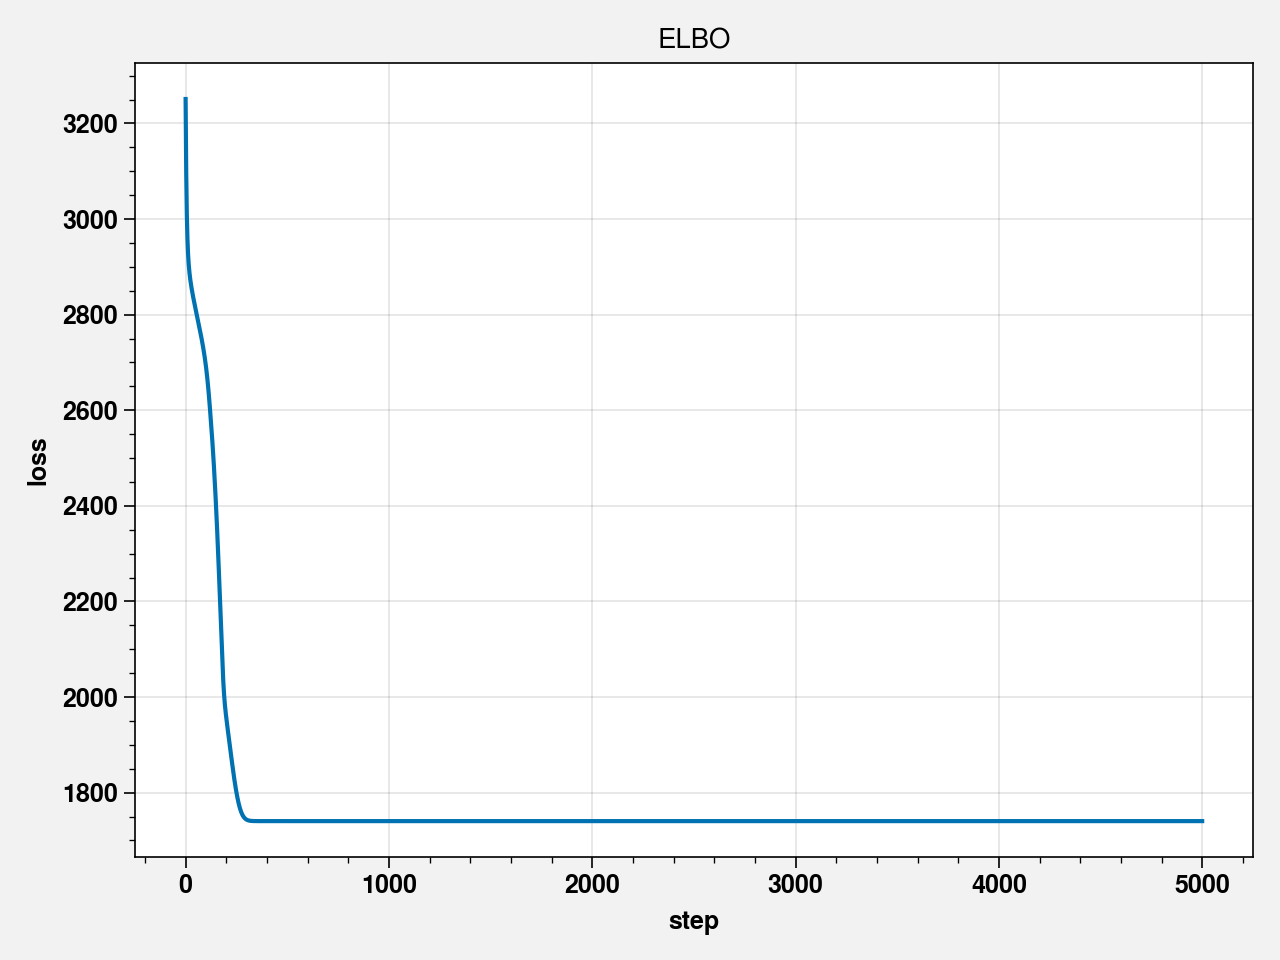

In [ ]:
howell['weight_s2'] = howell['weight_s']**2

def model45(weight, weight_s2):

  a = pyro.sample("a", dist.Normal(tensor(178.), tensor(100.)))
  b1 = pyro.sample("b1", dist.Normal(tensor(0.), tensor(10.)))
  b2 = pyro.sample("b2", dist.Normal(tensor(0.), tensor(10.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(50.)))
  mu = a + b1*weight + b2*weight_s2
  height = pyro.sample("height", dist.Normal(mu, sigma))
  return height 

def guide45(weight, weight_s2):
  a_param = pyro.param("a_param", tensor(140.))
  b1_param = pyro.param("b1_param", tensor(10.))
  b2_param = pyro.param("b2_param", tensor(10.))
  sigma_param = pyro.param("sigma_param", tensor(20.), constraint=constraints.positive)
  return (pyro.sample("a", dist.Delta(a_param)), pyro.sample("b1", dist.Delta(b1_param)), pyro.sample("b2", dist.Delta(b2_param)), 
          pyro.sample("sigma", dist.Delta(sigma_param)))

howell_height = tensor(howell['height'], dtype=torch.float)
howell_weight = tensor(howell['weight_s'], dtype=torch.float)
howell_weight_s2 = tensor(howell['weight_s2'], dtype=torch.float)

conditioned45 = pyro.condition(model45, data={"height": howell_height})
pyro.clear_param_store()
svi = pyro.infer.SVI(
    model=conditioned45,
    guide=guide45,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)


num_steps = 5000
losses = [svi.step(howell_weight, howell_weight_s2) for t in range(num_steps)]
coef_m45_a = pyro.param("a_param").item()
coef_m45_b1 = pyro.param("b1_param").item()
coef_m45_b2 = pyro.param("b2_param").item()
coef_m45_sigma = pyro.param("sigma_param").item()


guide45 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned45)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned45,
    guide=guide45,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(howell_weight, howell_weight_s2) for t in range(num_steps)]
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
laplace_guide45 = guide45.laplace_approximation(howell_weight, howell_weight_s2)
pred45 = pyro.infer.Predictive(laplace_guide45, num_samples=1000)

# Code 4.67

In [ ]:
summary(pred45.get_samples())

,_AutoMultivariateNormal_latent,a,b1,b2,sigma
mean,"[146.66927, 21.398947, -8.422605, -2.0386057]",146.66917,21.39895,-8.422608,5.762513
std,"[0.38244662, 0.28605404, 0.28239244, 0.032499902]",0.38244662,0.28605404,0.28239244,0.16579546
5.0%,"[146.02217, 20.92644, -8.913973, -2.0917897]",146.02217,20.92644,-8.913973,5.494869
95.0%,"[147.2936, 21.871164, -7.955038, -1.983937]",147.2936,21.871164,-7.955038,6.044988


# Code 4.68

In [ ]:
def link(laplace_guide, data1, data2, num_samples):
  pred = pyro.infer.Predictive(laplace_guide, num_samples=num_samples)
  samples = pred.get_samples()
  mu = samples["b2"].detach().reshape((num_samples,1))*data2.T.reshape(1, data2.shape[0]) + samples["b1"].detach().reshape((num_samples,1))*data1.T.reshape(1, data1.shape[0]) + samples["a"].detach().reshape((num_samples,1))
  return mu

def sim(pred, data1, data2, num_samples=1000):
  samples = pred.get_samples()
  mu = samples["b2"].detach().reshape((num_samples,1))*data2.T.reshape(1, data2.shape[0]) + samples["b1"].detach().reshape((num_samples,1))*data1.T.reshape(1, data1.shape[0]) + samples["a"].detach().reshape((num_samples,1))
  sigma = samples["sigma"].reshape(num_samples,1)
  height_sampled = dist.Normal(mu, 
                               sigma).sample()
  return height_sampled

weight_seq = torch.linspace(-2.2, 2, steps=30)
mu = link(laplace_guide45, weight_seq, weight_seq**2, 1000)
mu_mean = mu.mean(0)
mu_PI = stats.pi(mu, dim=0, prob=0.89)
sim_height = sim(pred45, weight_seq, weight_seq**2)
height_PI = stats.pi(sim_height, prob=0.89, dim=0)

# Code 4.69

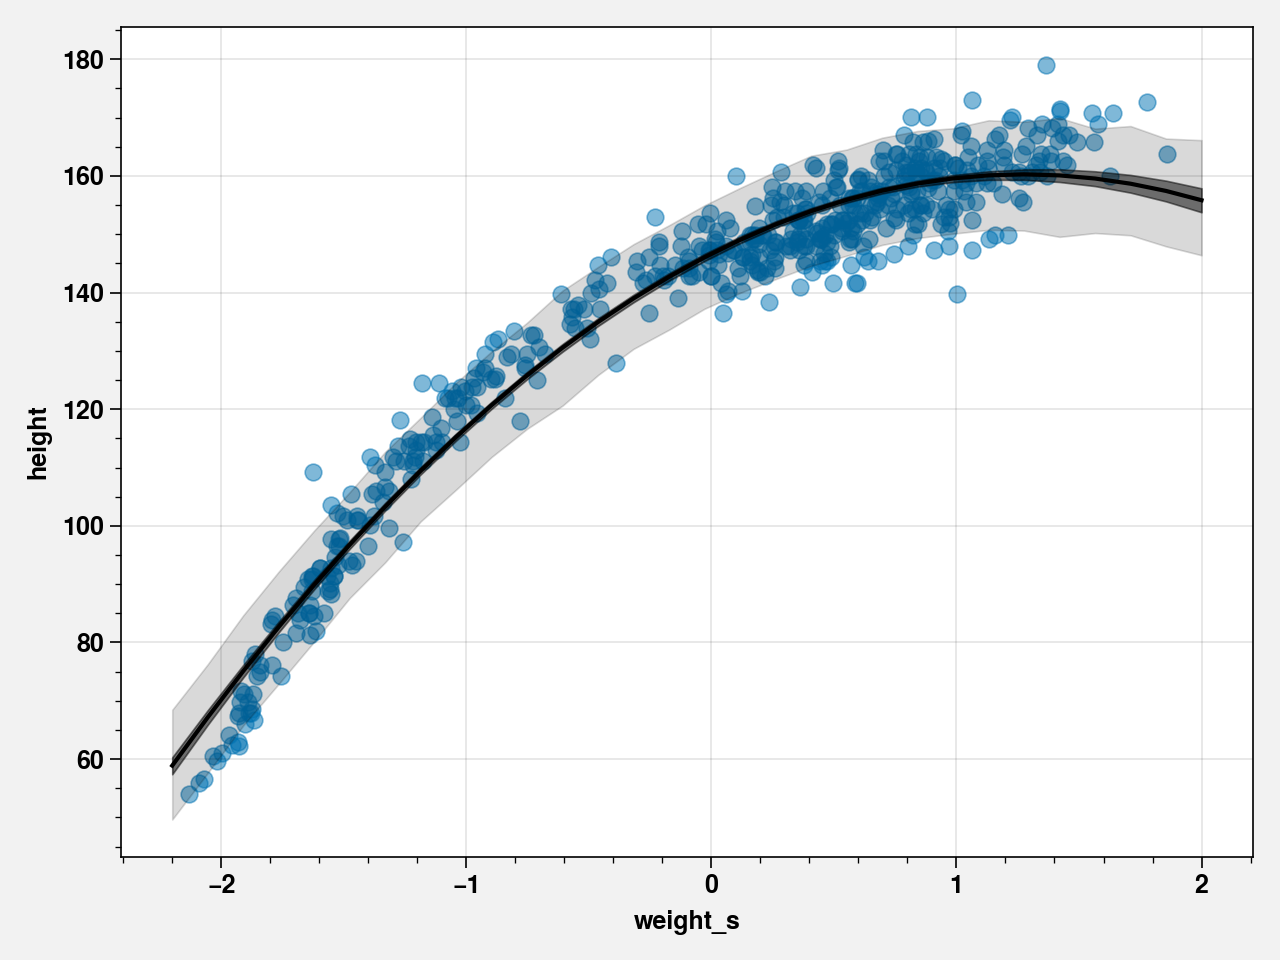

In [ ]:
# plot raw data
fig, ax = plt.subplots()
ax.scatter(howell["weight_s"], howell["height"], alpha=0.5)
ax.plot(weight_seq, mu_mean, color="k")
ax.fill_between(weight_seq, mu_PI[0].detach().numpy(), mu_PI[1].detach().numpy(), color="k", alpha=0.5)
ax.fill_between(weight_seq, height_PI[0].detach().numpy(), height_PI[1].detach().numpy(), color="k", alpha=0.15)
ax.set_xlabel('weight_s')
ax.set_ylabel('height')
fig.tight_layout()

# Code 4.70

In [ ]:
howell['weight_s2'] = howell['weight_s']**2
howell['weight_s3'] = howell['weight_s']**3

def model46(weight, weight_s2, weight_s3):

  a = pyro.sample("a", dist.Normal(tensor(178.), tensor(100.)))
  b1 = pyro.sample("b1", dist.Normal(tensor(0.), tensor(10.)))
  b2 = pyro.sample("b2", dist.Normal(tensor(0.), tensor(10.)))
  b3 = pyro.sample("b3", dist.Normal(tensor(0.), tensor(10.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(50.)))
  mu = a + b1*weight + b2*weight_s2 + b3*weight_s3
  height = pyro.sample("height", dist.Normal(mu, sigma))
  return height 



howell_height = tensor(howell['height'], dtype=torch.float)
howell_weight = tensor(howell['weight_s'], dtype=torch.float)
howell_weight_s2 = tensor(howell['weight_s2'], dtype=torch.float)
howell_weight_s3 = tensor(howell['weight_s3'], dtype=torch.float)

conditioned46 = pyro.condition(model46, data={"height": howell_height})
pyro.clear_param_store()

guide46 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned46)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned46,
    guide=guide46,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(howell_weight, howell_weight_s2, howell_weight_s3) for t in range(num_steps)]
laplace_guide46 = guide46.laplace_approximation(howell_weight, howell_weight_s2, howell_weight_s3)
pred46 = pyro.infer.Predictive(laplace_guide46, num_samples=1000)

# Code 4.71

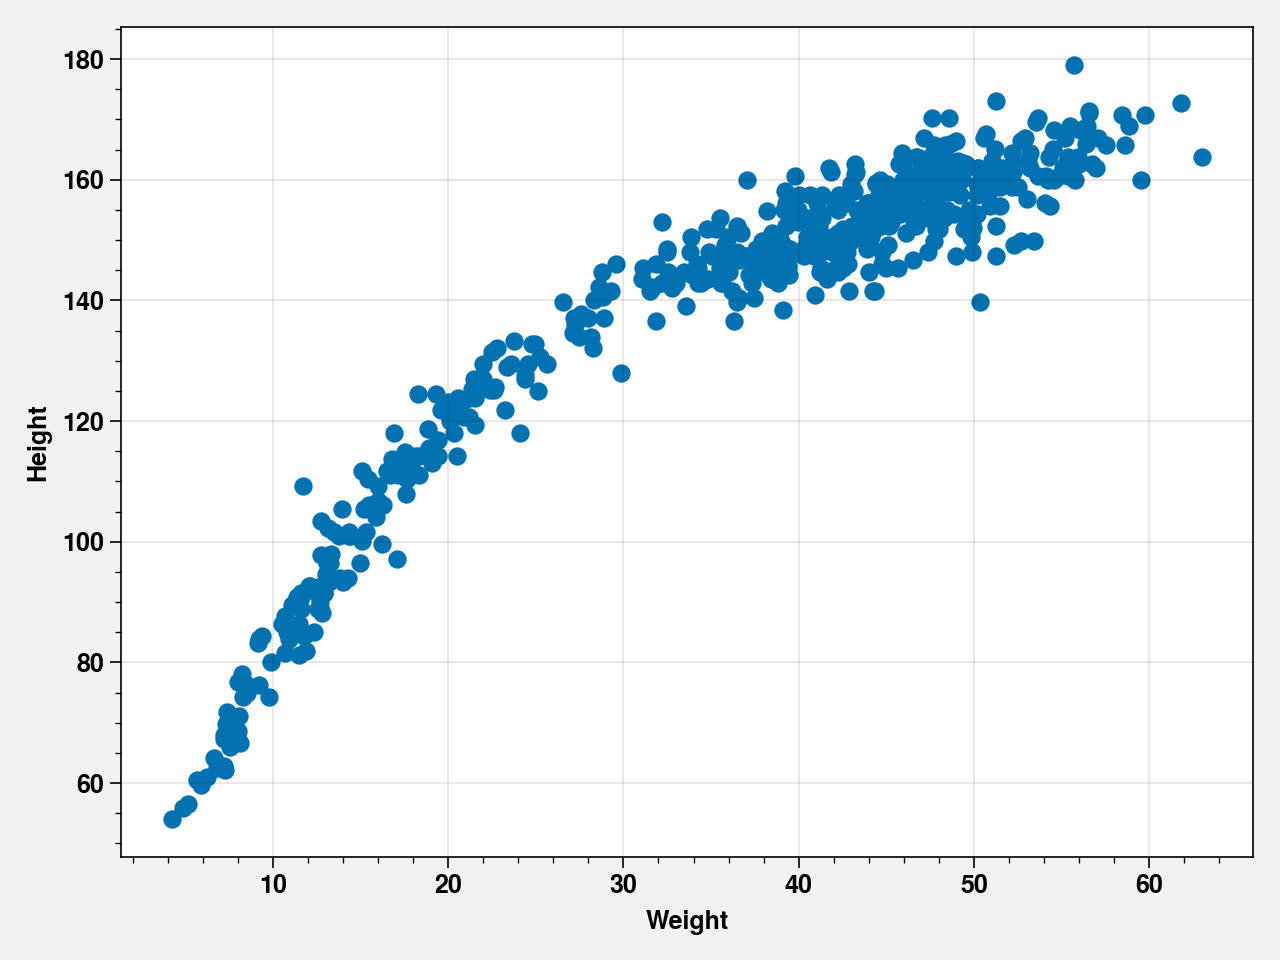

In [ ]:
fig, ax = plt.subplots()
ax.scatter(howell['weight'], howell['height'])
ax.set_xlabel('Weight')
ax.set_ylabel('Height')
fig.tight_layout()

# Code 4.72

Text(0, 0.5, 'Height')

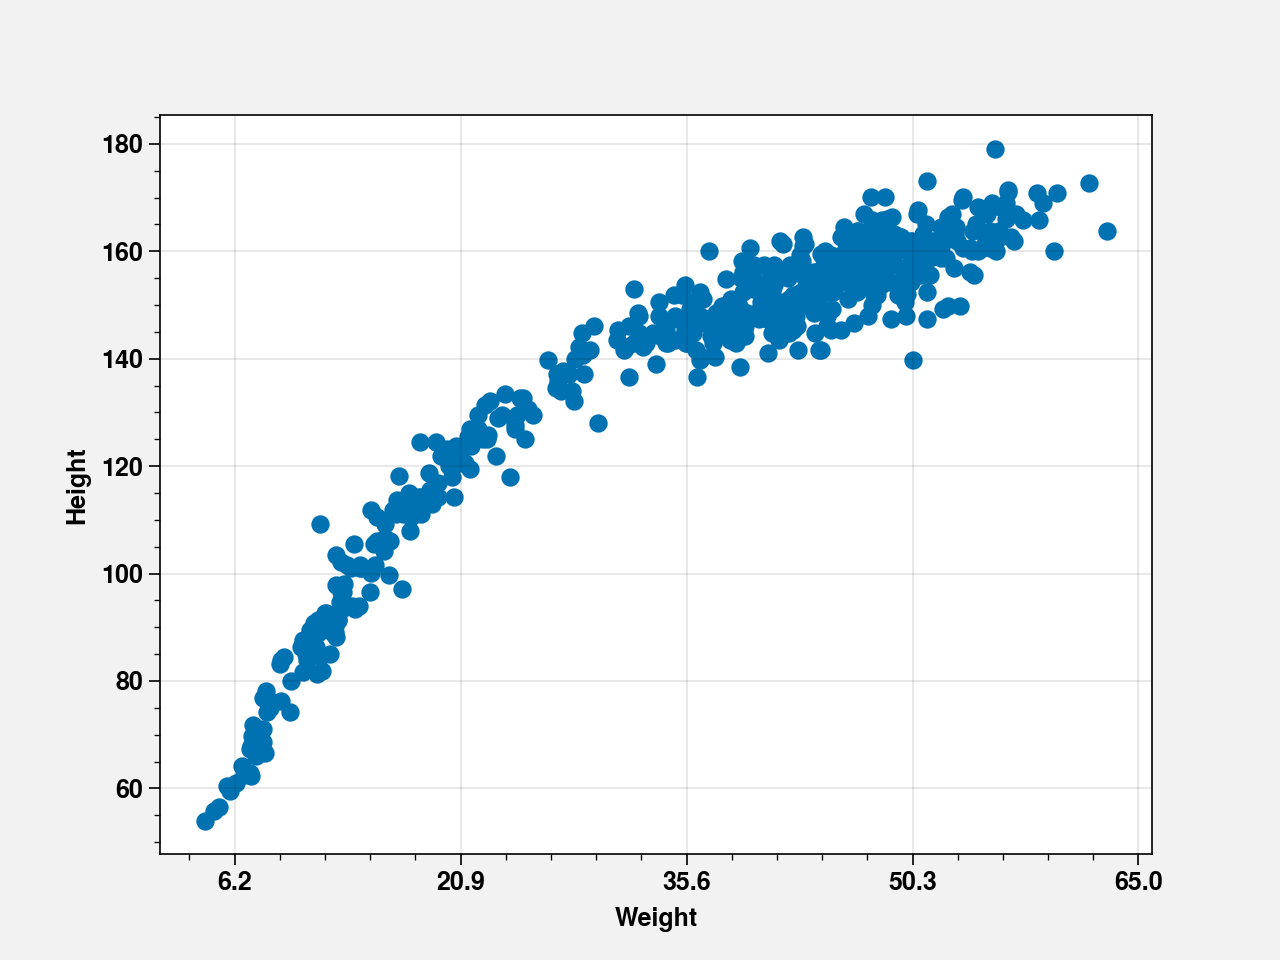

In [ ]:
at = torch.tensor([-2, -1, 0, 1, 2])
labels = at * howell['weight'].std() + howell['weight'].mean()
fig, ax = plt.subplots()
ax.scatter(howell['weight_s'], howell['height'])
ax.set_xticks(at)
ax.set_xticklabels([round(label.item(), 1) for label in labels])


ax.set_xlabel('Weight')
ax.set_ylabel('Height')